<font size="10">CAR CRASHES ANALYSIS: CINCINNATI


# INTRODUCTION:

<font size="5">Scope of the project:

The scope of this project is to analyze the available data concerning people involved in car crashes in Cincinnati (from 2010-02-23 to 2021-01-14) and try to define predictors of the severity of the crash and any resulting injuries. Moreover, an attempt will be made to extract details that might indicate what actions to undertake to effectively improve precautionary measures.

<font size="5">Importing the libraries:

In [ ]:
import zipfile
import textwrap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font size="5">Importing the data:</font>

In [ ]:
zip_file_path = "/content/drive/MyDrive/My projects/Cincinnati car crashes/Cincinnati_CC.zip"
csv_file_name = "cincinnati_traffic_crash_data__cpd.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_file_name) as file:
        df_original = pd.read_csv(file)

pd.set_option('display.max_columns', None)
# generating a copy of the dataset to work on, so that the original data remains unchanged
df = df_original.copy()


<ipython-input-140-e1e2d023cf49>:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(file)


The dataset used is "Cincinnati Car Crash Data Since 2010" from Kaggle. The data has been obtained from data.cincinnati-oh.gov. In compliance with privacy laws, all Public Safety datasets are anonymized. Each row of the dataset corresponds to a person who has been involved in a car crash.

# DATA EXPLORATION AND CLEANING

<font size="5">Checking the dataset shape:

In [ ]:
# checking the dataset shape
print(df.shape[0])
print(df.shape[1])


258672
27


The dataset adheres to the typical criterion of having a substantially greater number of rows compared to the number of variables. The aim is to maintain this condition even after the process of data exploration and cleaning.

<font size="5">Checking for duplicates:


In [ ]:
duplicates = df.duplicated(subset=None, keep='first')
num_duplicates = sum(duplicates)
print("Number of Duplicates:", num_duplicates)


Number of Duplicates: 0


The dataset presents no duplicates.

<font size="5">Checking the dataset variables:


In [ ]:
print(df.columns.tolist())


['Unnamed: 0', 'ADDRESS_X', 'LATITUDE_X', 'LONGITUDE_X', 'AGE', 'COMMUNITY_COUNCIL_NEIGHBORHOOD', 'CPD_NEIGHBORHOOD', 'CRASHDATE', 'CRASHLOCATION', 'CRASHSEVERITY', 'CRASHSEVERITYID', 'DATECRASHREPORTED', 'DAYOFWEEK', 'GENDER', 'INJURIES', 'INSTANCEID', 'LIGHTCONDITIONSPRIMARY', 'LOCALREPORTNO', 'MANNEROFCRASH', 'ROADCONDITIONSPRIMARY', 'ROADCONTOUR', 'ROADSURFACE', 'SNA_NEIGHBORHOOD', 'TYPEOFPERSON', 'WEATHER', 'ZIP', 'UNITTYPE']


The available car crashes details are the following:

* **Unnamed: 0**: Apparently, a duplicate of the index, shifted by 19;
* **ADDRESS_X**: Partially redacted address of reported crash;
* **LATITUDE_X**: Latitude of reported crash;
* **LONGITUDE_X**:  Longitude of reported crash;
* **AGE**: Age of the individual;
* **COMMUNITY_COUNCIL_NEIGHBORHOOD**: Community neighborhood name where the crash was reported;
* **CPD_NEIGHBORHOOD**: Cincinnati Police District of the neighborhood;
* **CRASHDATE**: Date of the crash;
* **CRASHLOCATION**: Type of location of where the crash occurred;
* **CRASHSEVERITY**: Indicator of how server the crash was (condition of the most damaged individual);
* **CRASHSEVERITYID**: ID for the crash serverity;
* **DATECRASHREPORTED**: Date when the crash was reported;
* **DAYOFWEEK**: Day of the week the crash occurred;
* **GENDER**: Gender of the individual;
* **INJURIES**: Indicator for injuries resulted from the crash;
* **INSTANCEID**: ID of the crash;
* **LIGHTCONDITIONSPRIMARY**: Light condition of when the crash occurred;
* **LOCALREPORTNO**: Local reporting number;
* **MANNEROFCRASH**: The type of crash;
* **ROADCONDITIONSPRIMARY**: Reported road conditions when the crash occurred;
* **ROADCONTOUR**: The type of road contour the crash occurred on;
* **ROADSURFACE**: The type of road surface the crash occurred on;
* **SNA_NEIGHBORHOOD**: The Statistical Neighborhood Approximation location;
* **TYPEOFPERSON**: Which type of person was involved in the crash;
* **WEATHER**: The weather at the time of the crash;
* **ZIP**: Zip Code of the where the crash occurred;
* **UNITTYPE**: The type of car involved in the crash;

<font size="5">Dropping variables that are out of the scope of the project:


In [ ]:
# dropping variables

df.drop('Unnamed: 0', axis=1, inplace=True)
# not needed
df.drop('ADDRESS_X', axis=1, inplace=True)
# not needed
df.drop('LATITUDE_X', axis=1, inplace=True)
# not needed
df.drop('LONGITUDE_X', axis=1, inplace=True)
# not needed
df.drop('COMMUNITY_COUNCIL_NEIGHBORHOOD', axis=1, inplace=True)
# not needed
df.drop('CPD_NEIGHBORHOOD', axis=1, inplace=True)
# not needed
df.drop('CRASHSEVERITYID', axis=1, inplace=True)
# redundant (CRASHSEVERITY)
df.drop('DATECRASHREPORTED', axis=1, inplace=True)
# not needed
df.drop('LOCALREPORTNO', axis=1, inplace=True)
# redundant (INSTANCEID)
df.drop('ZIP', axis=1, inplace=True)
# not needed


These informations are either not relevant for the current reserch or they are redundant.

<font size="5"> Editing modalities:

In [ ]:
# cleaning CRASHLOCATION modalities
df['CRASHLOCATION'] = df['CRASHLOCATION'].str.split(' - ').str[1]

# cleaning CRASHSEVERITY modalities
df['CRASHSEVERITY'] = df['CRASHSEVERITY'].str.split(' - ').str[1]
CRASHSEVERITY_dict = {
    "PROPERTY DAMAGE ONLY (PDO)" : "PROPERTY DAMAGE ONLY"
}
df['CRASHSEVERITY'] = df['CRASHSEVERITY'].replace(CRASHSEVERITY_dict)

# cleaning GENDER modalities
# the reason why the dictionary editing comes before here is because some values were getting nullified
GENDER_dict = {
    "MALE" : "M - MALE",
    "FEMALE" : "F - FEMALE"
}
df['GENDER'] = df['GENDER'].replace(GENDER_dict)
df['GENDER'] = df['GENDER'].str.split(' - ').str[1]

# cleaning INJURIES modalities
df['INJURIES'] = df['INJURIES'].str.split(' - ').str[1]
INJURIES_dict = {
    "POSSIBLE" : "POSSIBLE INJURY",
}
df['INJURIES'] = df['INJURIES'].replace(INJURIES_dict)

# cleaning LIGHTCONDITIONSPRIMARY modalities
df['LIGHTCONDITIONSPRIMARY'] = df['LIGHTCONDITIONSPRIMARY'].str.split(' - ').str[1]
LIGHTCONDITIONSPRIMARY_dict = {
    "DARK – ROADWAY NOT LIGHTIED" : "DARK – ROADWAY NOT LIGHTED",
    "OTHER" : "UNKNOWN"
}
df['LIGHTCONDITIONSPRIMARY'] = df['LIGHTCONDITIONSPRIMARY'].replace(LIGHTCONDITIONSPRIMARY_dict)

# cleaning MANNEROFCRASH modalities
df['MANNEROFCRASH'] = df['MANNEROFCRASH'].str.split(' - ').str[1]

# cleaning ROADCONDITIONSPRIMARY modalities
df['ROADCONDITIONSPRIMARY'] = df['ROADCONDITIONSPRIMARY'].str.split(' - ').str[1]
ROADCONDITIONSPRIMARY_dict = {
    "OTHER" : "UNKNOWN"
}
df['ROADCONDITIONSPRIMARY'] = df['ROADCONDITIONSPRIMARY'].replace(ROADCONDITIONSPRIMARY_dict)

# cleaning ROADCONTOUR modalities
df['ROADCONTOUR'] = df['ROADCONTOUR'].str.split(' - ').str[1]

# cleaning ROADSURFACE modalities
df['ROADSURFACE'] = df['ROADSURFACE'].str.split(' - ').str[1]
ROADSURFACE_dict = {
    "OTHER" : "UNKNOWN"
}
df['ROADSURFACE'] = df['ROADSURFACE'].replace(ROADSURFACE_dict)

# cleaning TYPEOFPERSON modalities
df['TYPEOFPERSON'] = df['TYPEOFPERSON'].str.split(' - ').str[1]

# cleaning WEATHER modalities
df['WEATHER'] = df['WEATHER'].str.split(' - ').str[1]
WEATHER_dict = {
    "SLEET,HAIL" : "SLEET, HAIL",
    "OTHER/UNKNOWN" : "UNKNOWN"
}
df['WEATHER'] = df['WEATHER'].replace(WEATHER_dict)

# cleaning TYPEOFPERSON modalities
df['UNITTYPE'] = df['UNITTYPE'].str.split(' - ').str[1]


Changes to the following features have been applied for the following reasons:

*   CRASHLOCATION, CRASHSEVERITY, GENDER, INJURIES, LIGHTCONDITIONSPRIMARY, MANNEROFCRASH, ROADCONDITIONSPRIMARY, ROADCONTOUR, ROADSURFACE, TYPEOFPERSON, WEATHER, UNITTYPE: The categories of these features have been cleaned for easier interpretation.
*   CRASHSEVERITY, INJURIES, LIGHTCONDITIONSPRIMARY, ROADCONDITIONSPRIMARY, ROADSURFACE, WEATHER: Some categories of these variables had inaccurate spelling or other factors that would cause the code to perceive them as additional categories.


<font size="5"> Missing data:

In [ ]:
# creating a function to get insights about the missing data
def nan_info(dataframe):
    nan_counts = dataframe.isnull().sum()
    total_rows = len(dataframe)
    nan_percentages = nan_counts / total_rows * 100
    nan_columns = nan_counts[nan_counts > 0].index.tolist()

    print("NaN Information:")
    print("Total Rows:", total_rows)
    print("\nColumns with NaN values:")
    print(nan_columns)

    if nan_columns:
        print("\nNaN Counts:")
        print(nan_counts[nan_columns])

        print("\nNaN Percentages:")
        print(nan_percentages[nan_columns])

nan_info(df)

NaN Information:
Total Rows: 258672

Columns with NaN values:
['CRASHDATE', 'CRASHLOCATION', 'DAYOFWEEK', 'GENDER', 'INJURIES', 'LIGHTCONDITIONSPRIMARY', 'MANNEROFCRASH', 'ROADCONDITIONSPRIMARY', 'ROADCONTOUR', 'ROADSURFACE', 'SNA_NEIGHBORHOOD', 'TYPEOFPERSON', 'WEATHER', 'UNITTYPE']

NaN Counts:
CRASHDATE                     3
CRASHLOCATION             64651
DAYOFWEEK                     1
GENDER                    28989
INJURIES                    222
LIGHTCONDITIONSPRIMARY        2
MANNEROFCRASH                 1
ROADCONDITIONSPRIMARY         2
ROADCONTOUR                   2
ROADSURFACE                   2
SNA_NEIGHBORHOOD           5737
TYPEOFPERSON                222
WEATHER                       2
UNITTYPE                    222
dtype: int64

NaN Percentages:
CRASHDATE                 0.00
CRASHLOCATION            24.99
DAYOFWEEK                 0.00
GENDER                   11.21
INJURIES                  0.09
LIGHTCONDITIONSPRIMARY    0.00
MANNEROFCRASH             0.00
ROADCO

<font size="5"> Dealing with missing data:

In [ ]:
# # dropping rows with few nan values
df.dropna(subset=['CRASHDATE'], inplace=True)
df.dropna(subset=['DAYOFWEEK'], inplace=True)
df.dropna(subset=['INJURIES'], inplace=True)
df.dropna(subset=['TYPEOFPERSON'], inplace=True)

# changing nan values to "UNKNOWN"
df['CRASHLOCATION'] = df['CRASHLOCATION'].fillna('UNKNOWN')
df['GENDER'] = df['GENDER'].fillna('UNKNOWN')
df['LIGHTCONDITIONSPRIMARY'] = df['LIGHTCONDITIONSPRIMARY'].fillna('UNKNOWN')
df['MANNEROFCRASH'] = df['MANNEROFCRASH'].fillna('UNKNOWN')
df['ROADCONDITIONSPRIMARY'] = df['ROADCONDITIONSPRIMARY'].fillna('UNKNOWN')
df['ROADCONTOUR'] = df['ROADCONTOUR'].fillna('UNKNOWN')
df['ROADSURFACE'] = df['ROADSURFACE'].fillna('UNKNOWN')
df['SNA_NEIGHBORHOOD'] = df['SNA_NEIGHBORHOOD'].fillna('UNKNOWN')
df['WEATHER'] = df['WEATHER'].fillna('UNKNOWN')
df['UNITTYPE'] = df['UNITTYPE'].fillna('UNKNOWN')


For information that does not have an "UNKNOWN" category among its current values, rows with null values have been eliminated. The only exception is "SNA_NEIGHBORHOOD," which had over 2% of values missing. Due to the relatively high number of missing values, these have been changed to "UNKNOWN."

For information that already includes "UNKNOWN" among its categories, the null values have also been changed to "UNKNOWN."








<font size="5"> Editing variables types:

In [ ]:
# checking the types
print(df.dtypes)

AGE_categories = ["UNDER 18","18-25","26-30","31-40","41-50","51-60","61-70","OVER 70","UNKNOWN"]
CRASHSEVERITY_categories = ["PROPERTY DAMAGE ONLY","MINOR INJURY SUSPECTED","INJURY POSSIBLE","INJURY","SERIOUS INJURY SUSPECTED","FATAL INJURY","FATAL"]
INJURIES_categories = ["NO INJURY / NONE REPORTED","NO APPARENTY INJURY","SUSPECTED MINOR INJURY","POSSIBLE INJURY","NON-INCAPACITATING","SUSPECTED SERIOUS INJURY","INCAPACITATING", "FATAL"]

# changing the types according to personal considerations
df['AGE'] = pd.Categorical(df['AGE'], categories=AGE_categories, ordered=True)
df['CRASHDATE'] = pd.to_datetime(df['CRASHDATE'], format='%m/%d/%Y %I:%M:%S %p')
df['CRASHLOCATION'] = pd.Categorical(df['CRASHLOCATION'])
df['CRASHSEVERITY'] = pd.Categorical(df['CRASHSEVERITY'], categories=CRASHSEVERITY_categories, ordered=True)
df['DAYOFWEEK'] = pd.Categorical(df['DAYOFWEEK'])
df['GENDER'] = pd.Categorical(df['GENDER'])
df['INJURIES'] = pd.Categorical(df['INJURIES'], categories=INJURIES_categories, ordered=True)
df['LIGHTCONDITIONSPRIMARY'] = pd.Categorical(df['LIGHTCONDITIONSPRIMARY'])
df['MANNEROFCRASH'] = pd.Categorical(df['MANNEROFCRASH'])
df['ROADCONDITIONSPRIMARY'] = pd.Categorical(df['ROADCONDITIONSPRIMARY'])
df['ROADCONTOUR'] = pd.Categorical(df['ROADCONTOUR'])
df['ROADSURFACE'] = pd.Categorical(df['ROADSURFACE'])
df['SNA_NEIGHBORHOOD'] = pd.Categorical(df['SNA_NEIGHBORHOOD'])
df['TYPEOFPERSON'] = pd.Categorical(df['TYPEOFPERSON'])
df['WEATHER'] = pd.Categorical(df['WEATHER'])
df['UNITTYPE'] = pd.Categorical(df['UNITTYPE'])


# checking the types again
print("")
print(df.dtypes)


AGE                       object
CRASHDATE                 object
CRASHLOCATION             object
CRASHSEVERITY             object
DAYOFWEEK                 object
GENDER                    object
INJURIES                  object
INSTANCEID                object
LIGHTCONDITIONSPRIMARY    object
MANNEROFCRASH             object
ROADCONDITIONSPRIMARY     object
ROADCONTOUR               object
ROADSURFACE               object
SNA_NEIGHBORHOOD          object
TYPEOFPERSON              object
WEATHER                   object
UNITTYPE                  object
dtype: object

AGE                             category
CRASHDATE                 datetime64[ns]
CRASHLOCATION                   category
CRASHSEVERITY                   category
DAYOFWEEK                       category
GENDER                          category
INJURIES                        category
INSTANCEID                        object
LIGHTCONDITIONSPRIMARY          category
MANNEROFCRASH                   category
ROADCONDITIONS

All variables have been converted to categorical type to better fit their nature, with the only exception of "CRASHDTE," which has been converted to datetime type, and INSTANCEID, which has been kept as an object.

Variables AGE, CRASHSEVERITY, and INJURY have been given an order. For the last two, the order has been personally inferred by me based on the provided categories, given the lack of a guide about the ground truth order.

<font size="5"> Distinction between car crashes and people:

Because each row in the dataset corresponds to a person involved in a car crash, analyzing information about car crashes would be heavily distorted by the fact that multiple people can be involved in a single crash. The variable INSTANCEID is used to generate a dataset where each row corresponds to a car crash to solve this problem. However, the "old" dataset will be kept to perform analyses on the individuals involved.

In [ ]:
consistent_columns = df.columns[df.columns != 'INSTANCEID']

perfect_relationship_columns = {}

for col in consistent_columns:
    if df.groupby('INSTANCEID')[col].nunique().eq(1).all():
        perfect_relationship_columns[col] = True
    else:
        perfect_relationship_columns[col] = False

# list of columns with perfect relationship with 'INSTANCEID'
perfect_columns_list = [col for col, is_perfect in perfect_relationship_columns.items() if is_perfect]

print(perfect_columns_list)

['CRASHDATE', 'CRASHLOCATION', 'CRASHSEVERITY', 'DAYOFWEEK', 'LIGHTCONDITIONSPRIMARY', 'MANNEROFCRASH', 'ROADCONDITIONSPRIMARY', 'ROADCONTOUR', 'ROADSURFACE', 'SNA_NEIGHBORHOOD', 'WEATHER']


What I did here was double-check that all variables concerning the car crash in general, and not the people involved, were perfectly correlated with INSTANCEID. I am glad to see that this was indeed the case. These are the columns that will be kept to generate the new car crashes dataset.

In [ ]:
# Create a new dataset with only the selected columns from df
df_crashes = df[perfect_columns_list].copy()
df_crashes = df_crashes.drop_duplicates()


<font size="5"> Shape of the clean datasets:

In [ ]:
# printing the shape of the injuried dataset
print(df.shape[0])
print(df.shape[1])

258448
17


In [ ]:
# printing the shape of the crashes dataset
print(df_crashes.shape[0])
print(df_crashes.shape[1])

133431
11


 # DESCRIPTIVE STATISTICS AND VISUALIZATION

The chosen approach for this section has been to remove the unknown values from a single variable when performing analysis on it. This allowed for retaining much more information at the cost of more computational power.

## CRASHES

<font size="5"> Frequencies for categorical variables:

In [ ]:
# tables of categorical variables

# temporarly excluding DATETIME
exclude_columns = [df_crashes.columns[0]]
categorical_variables = df_crashes.columns.difference(exclude_columns)

formatted_tables = []

for var in categorical_variables:
    # filtering the UNKNOWN data
    filtered_var = df_crashes[var].replace('UNKNOWN', np.nan).dropna()

    # absolute frequencies
    absolute_counts = filtered_var.value_counts().reset_index()
    absolute_counts.columns = ['Category', 'Absolute Frequency']

    # relative frequencies
    total_count = absolute_counts['Absolute Frequency'].sum()
    absolute_counts['Relative Frequency (%)'] = (absolute_counts['Absolute Frequency'] / total_count) * 100

    table_str = f"Table for Variable '{var}':\n\n"
    table_str += tabulate(absolute_counts, headers='keys', tablefmt='pretty', showindex=False)

    formatted_tables.append(table_str)

max_width = max(len(table.splitlines()[0]) for table in formatted_tables)

for table_str in formatted_tables:
    lines = table_str.splitlines()
    first_line = lines[0]
    remaining_lines = lines[1:]

    adjusted_first_line = first_line.ljust(max_width)

    print(adjusted_first_line)
    for line in remaining_lines:
        print(line)

    print("\n")


Table for Variable 'CRASHLOCATION':         

+----------------------------+--------------------+------------------------+
|          Category          | Absolute Frequency | Relative Frequency (%) |
+----------------------------+--------------------+------------------------+
|    NOT AN INTERSECTION     |       65278        |   65.26429449815538    |
|   FOUR-WAY INTERSECTION    |       18520        |   18.516111616560522   |
|       T-INTERSECTION       |        9878        |   9.875926055528339    |
|   DRIVEWAY/ALLEY ACCESS    |        2331        |   2.330510592775517    |
|          ON RAMP           |        1353        |   1.3527159296547724   |
|          OFF RAMP          |        1239        |   1.238739864628428    |
|       Y-INTERSECTION       |        941         |   0.9408024314893872   |
|    FIVE-POINT, OR MORE     |        249         |   0.2489477209785945   |
|         CROSSOVER          |         84         |  0.08398236370362223   |
| SHARED-USE PATHS OR TRAILS |

<font size="5"> Bar charts for categorical variables:

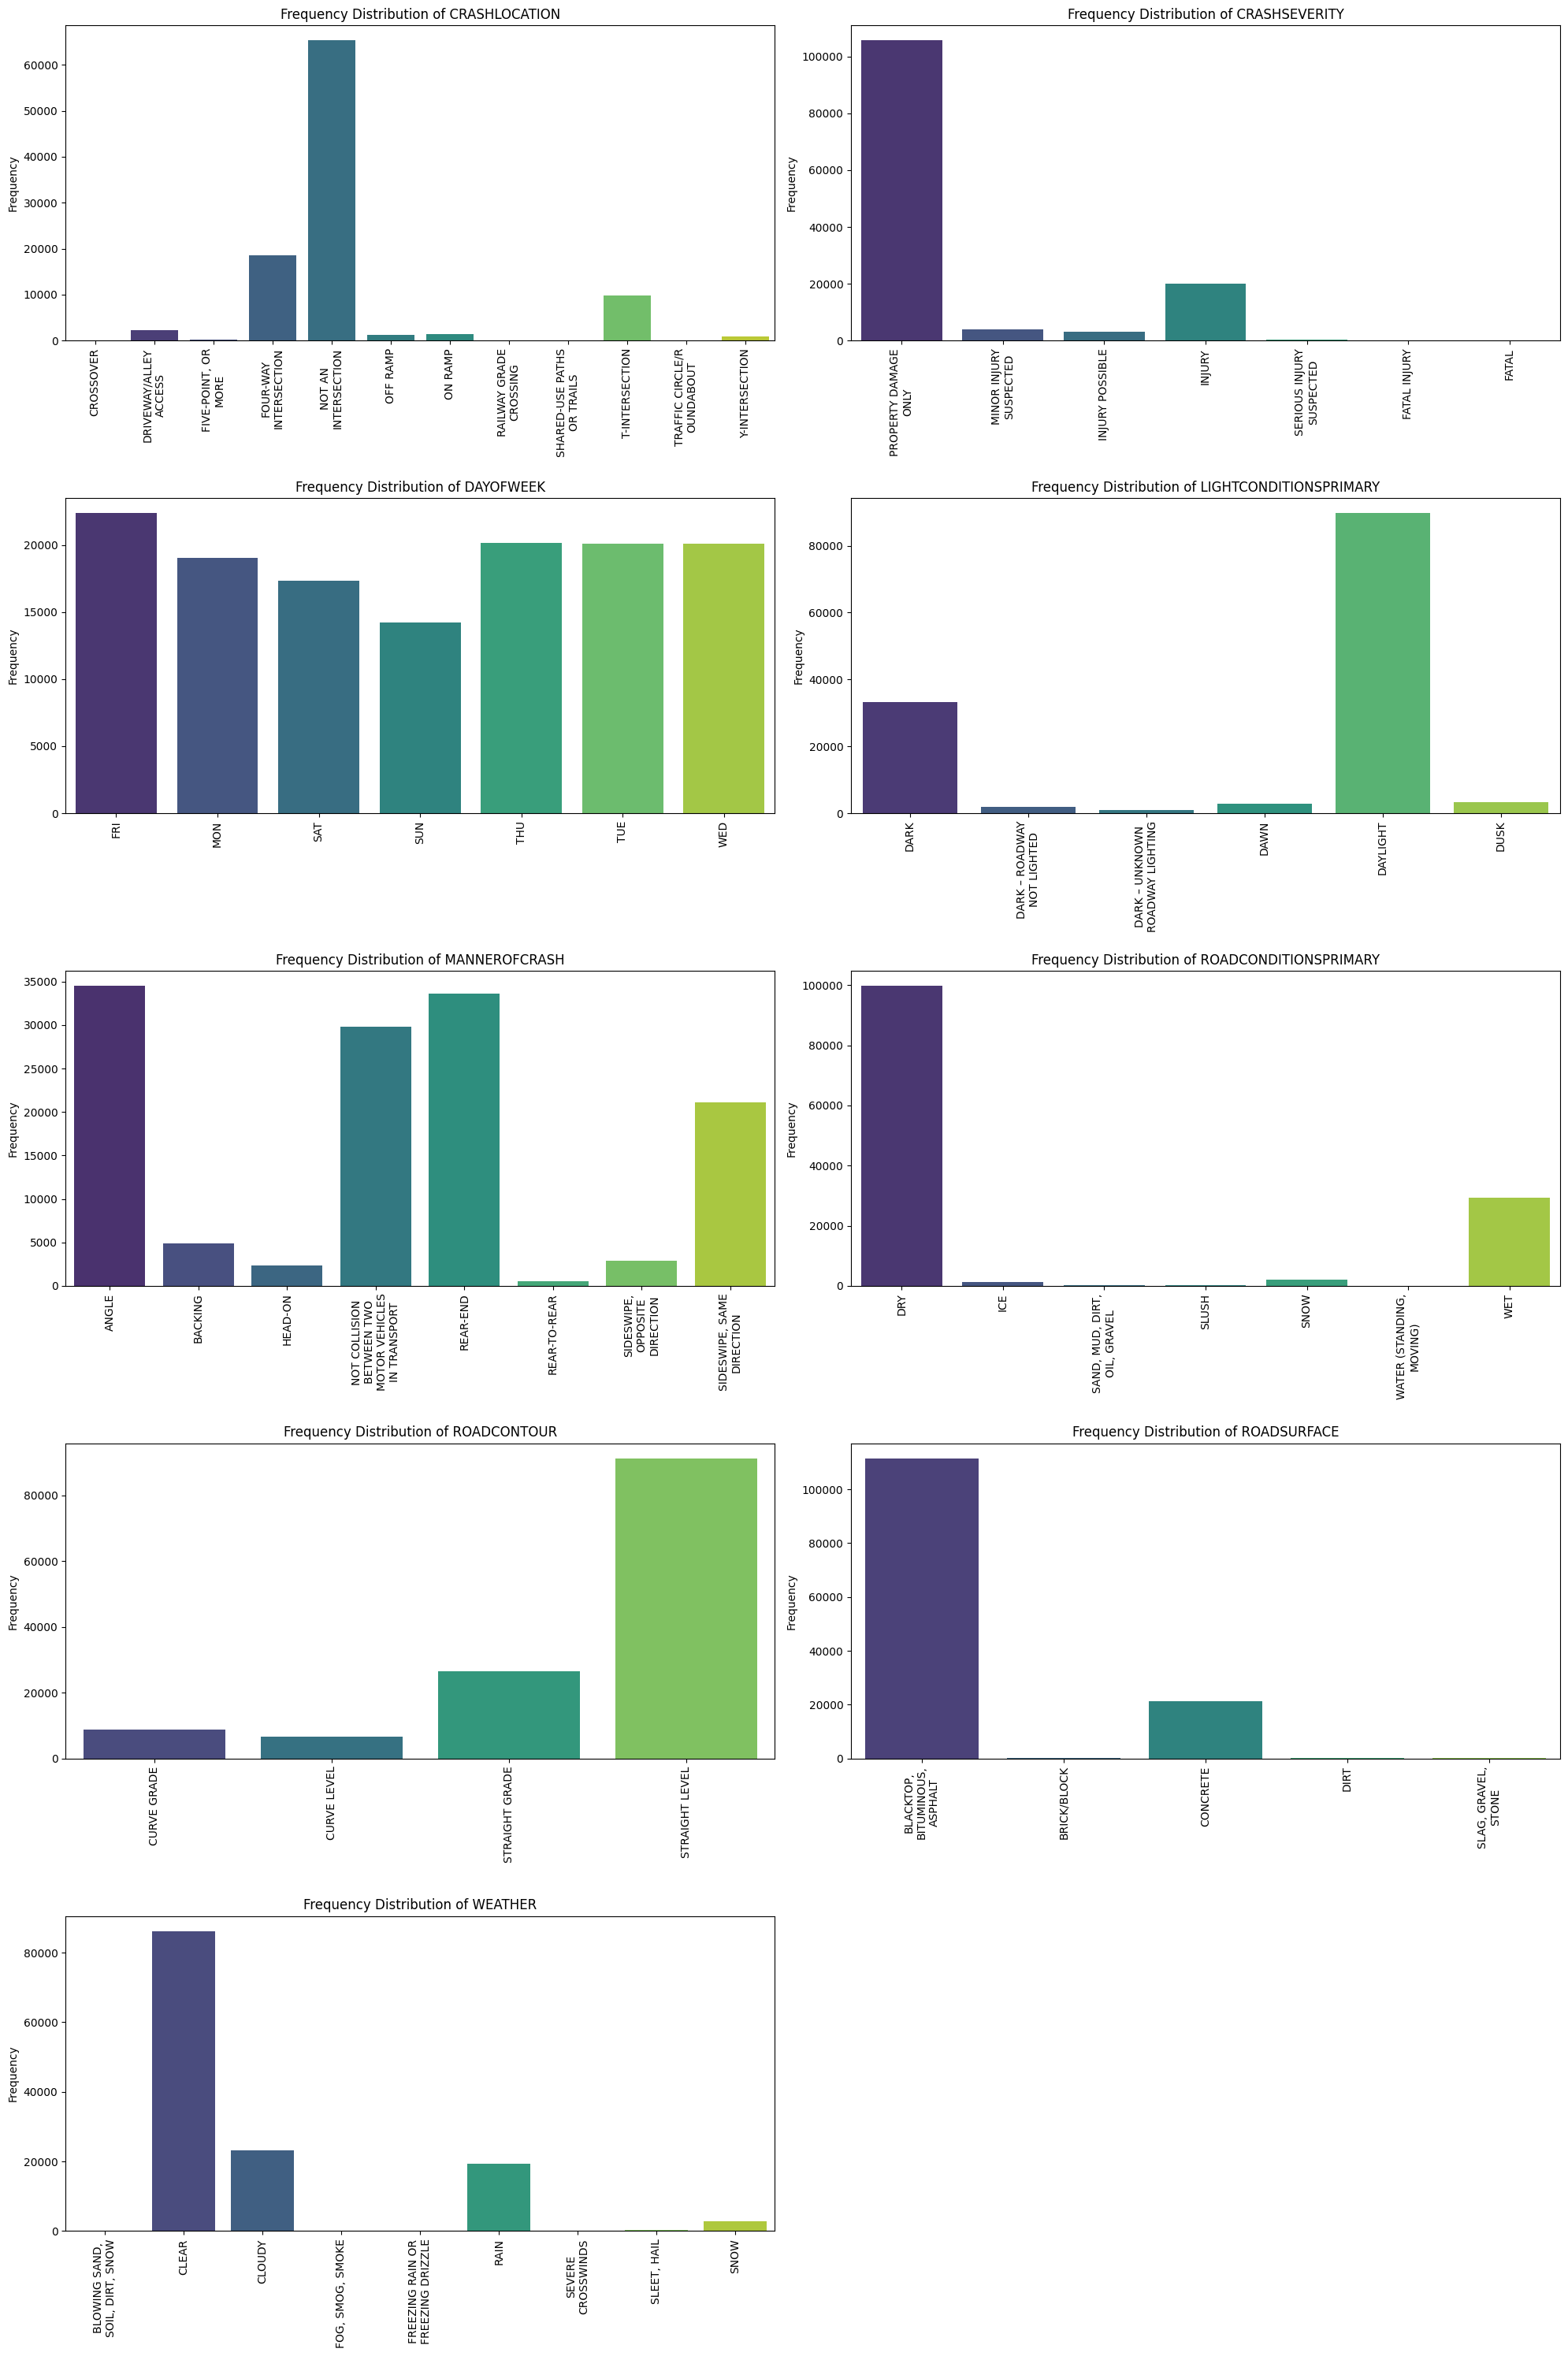

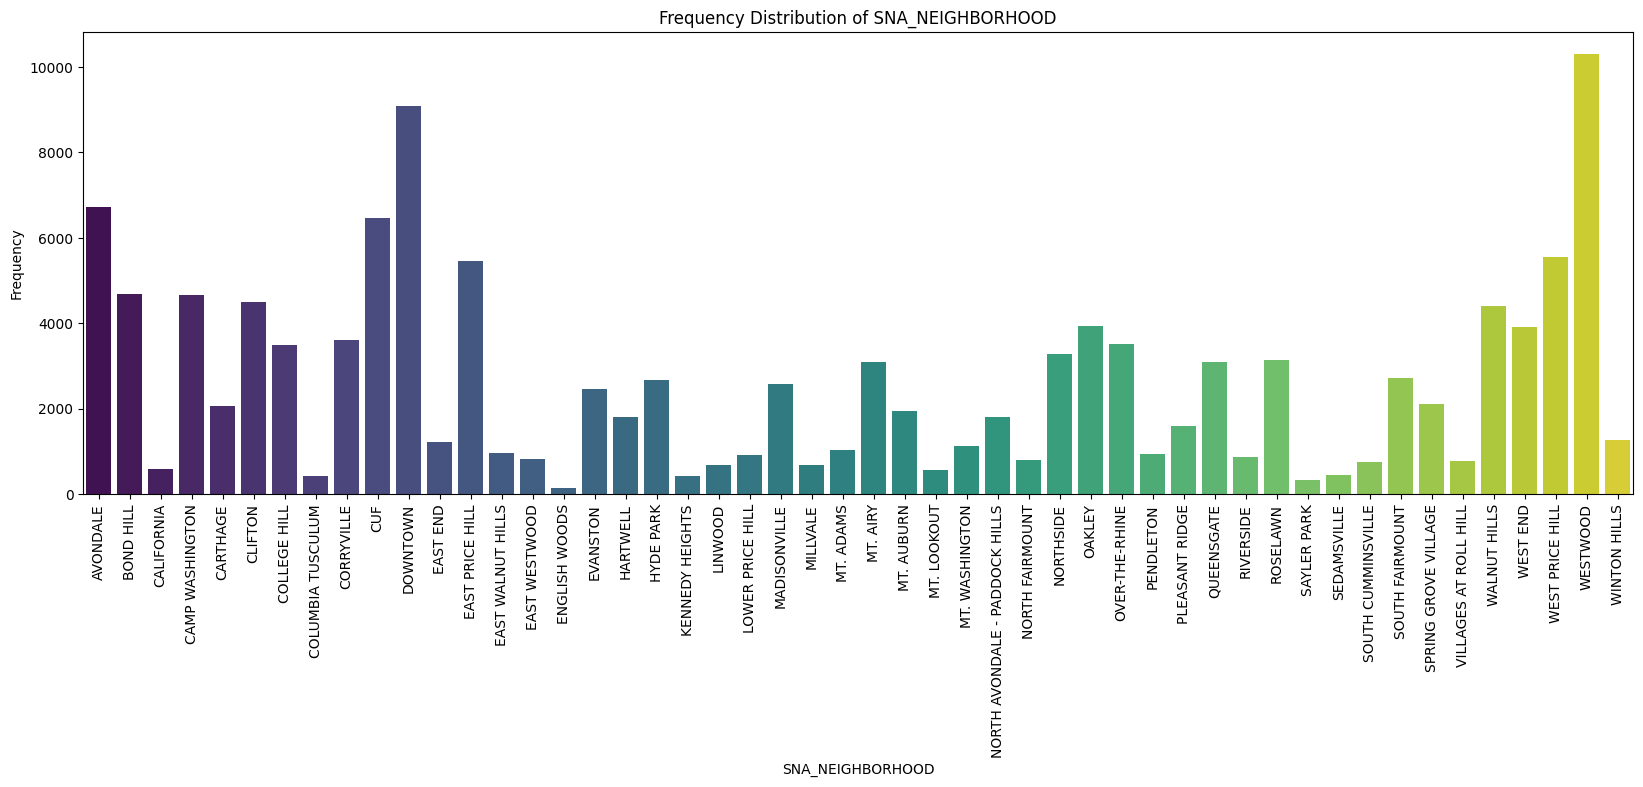

In [ ]:
# barplots of all the categorical variables

exclude_columns = [df_crashes.columns[0], df_crashes.columns[9]]
categorical_variables = df_crashes.columns.difference(exclude_columns)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

axes = axes.flatten()

# Helper function to split long labels
def wrap_labels(ax, labels, width=16):
    wrapped_labels = [textwrap.fill(label, width) for label in labels]
    ax.set_xticklabels(wrapped_labels)

warnings.filterwarnings("ignore", category=UserWarning)

# BAR CHARTS
for i, var in enumerate(categorical_variables):
    # filtering the UNKNOWN data
    filtered_var = df_crashes[var].replace('UNKNOWN', np.nan).dropna()
    if i < len(axes):
        ax = axes[i]
        sns.countplot(x=filtered_var, data=df_crashes, ax=ax, hue=filtered_var, palette='viridis', legend=False)
        ax.set_title(f'Frequency Distribution of {var}')
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=90)

        labels = [item.get_text() for item in ax.get_xticklabels()]
        wrap_labels(ax, labels)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# plot out of the grid for SNA_NEIGHBORHOOD, which counts much more modalities
filtered_SNA = df_crashes["SNA_NEIGHBORHOOD"].replace('UNKNOWN', np.nan).dropna()
plt.figure(figsize=(20, 6))
sns.countplot(x=filtered_SNA, hue=filtered_SNA, palette='viridis', dodge=False, legend=False)
plt.title('Frequency Distribution of SNA_NEIGHBORHOOD')
plt.xlabel('SNA_NEIGHBORHOOD')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Most crashes in Cincinnati did not occur at an interception (65.2%). About 85% of the crashes resulted in no harm to any of the people involved, with only damages to properties reported, and less than 0.2% of crashes resulting in a fatality. The distribution of crashes over the days of the week is uniform, with the exception of weekend days, with fewer crashes (on average) on Saturday and even fewer on Sunday, this might be because people work less during the weekend, and are therefore less prone to take the car, and fewer cars going
around means fewer car crashes (to be noted that this last assumption does not come from the available data, and comes exclusively from my own thoughts, under the hypothesis that more crashes happen where more cars are on the streets). Most crashes occur in daylight (68%), with clear weather (65%), on dry roads (75.4%), on a straight level of road contour (68.4%), and on asphalt/blacktop/bituminous (83.6%); and again this might be due to these being the most common conditions (again, my assumption, not coming from the available data). The two neighborhoods where there are the most car crashes are Westwood and Downtown (7.8% and 6.9%), and the most common type of crashes are angle crashes and rear-ends (26.6% and 25.9%).

<font size="5"> Frequencies for temporal variables:

In [ ]:
def get_season(date):
    year = date.year
    seasons = {
        'Winter': ((pd.Timestamp(year=year-1, month=12, day=21), pd.Timestamp(year=year, month=3, day=19)),
                   (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year+1, month=3, day=19))),
        'Spring': (pd.Timestamp(year=year, month=3, day=20), pd.Timestamp(year=year, month=6, day=20)),
        'Summer': (pd.Timestamp(year=year, month=6, day=21), pd.Timestamp(year=year, month=9, day=21)),
        'Fall': (pd.Timestamp(year=year, month=9, day=22), pd.Timestamp(year=year, month=12, day=20))
    }

    for season, ranges in seasons.items():
        if season == 'Winter':
            for start, end in ranges:
                if start <= date <= end:
                    return season
        else:
            start, end = ranges
            if start <= date <= end:
                return season

seasonal_counts = df_crashes['CRASHDATE'].apply(get_season).value_counts()
seasonal_counts_relative = seasonal_counts / seasonal_counts.sum() * 100

# Combine absolute and relative frequencies for seasons
seasonal_data = pd.DataFrame({
    'Season': seasonal_counts.index,
    'Absolute Frequency': seasonal_counts.values,
    'Relative Frequency (%)': seasonal_counts_relative.values
})


yearly_counts = df_crashes['CRASHDATE'].dt.year.value_counts().sort_index()
yearly_counts_relative = yearly_counts / yearly_counts.sum() * 100

# Combine absolute and relative frequencies for years
yearly_data = pd.DataFrame({
    'Year': yearly_counts.index,
    'Absolute Frequency': yearly_counts.values,
    'Relative Frequency (%)': yearly_counts_relative.values
})


seasonal_table = tabulate(seasonal_data, headers='keys', tablefmt='pretty', showindex=False)
yearly_table = tabulate(yearly_data, headers='keys', tablefmt='pretty', showindex=False)


print("Crashes per Seasons:")
print(seasonal_table)

print("Crashes per Year:")
print(yearly_table)


Crashes per Seasons:
+--------+--------------------+------------------------+
| Season | Absolute Frequency | Relative Frequency (%) |
+--------+--------------------+------------------------+
|  Fall  |       35173        |   26.660552266749537   |
| Summer |       33796        |   25.616809041226716   |
| Spring |       32051        |   24.294127902129176   |
| Winter |       30909        |   23.428510789894563   |
+--------+--------------------+------------------------+
Crashes per Year:
+--------+--------------------+------------------------+
|  Year  | Absolute Frequency | Relative Frequency (%) |
+--------+--------------------+------------------------+
| 2010.0 |        2.0         | 0.0014989020542452653  |
| 2012.0 |       986.0        |   0.7389587127429158   |
| 2013.0 |      12549.0       |   9.404860939361917    |
| 2014.0 |      13371.0       |   10.020909683656722   |
| 2015.0 |      17628.0       |   13.211322706117768   |
| 2016.0 |      19231.0       |   14.412692702595

<font size="5"> Bar charts for temporal variables:

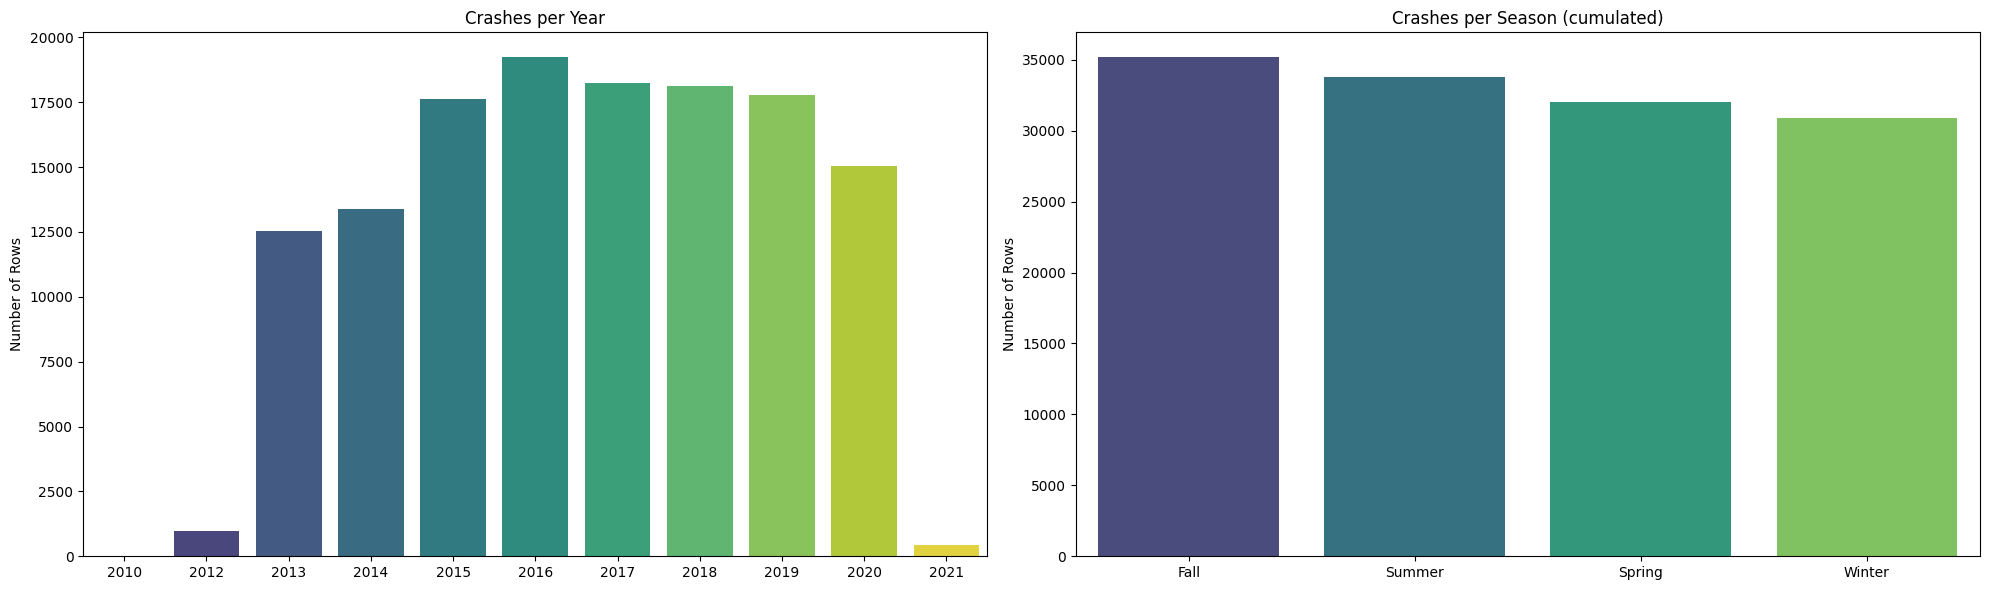

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Crashes per Year
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, hue=yearly_counts.index, palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Crashes per Year')
axes[0].set_xlabel('')
axes[0].set_ylabel('Number of Rows')
axes[0].tick_params(axis='x', rotation=0)

# Crashes per Season (cumulated)
sns.barplot(x=seasonal_counts.index, y=seasonal_counts.values, hue = seasonal_counts.index, palette='viridis', legend=False, ax=axes[1])
axes[1].set_title('Crashes per Season (cumulated)')
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Rows')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


Without taking into consideration the first 2 years available (2010 and 2012) and the last one (2021) because of the incompleteness of the data, Cincinnati has experienced a stable growth in reported car crashes from 2013 to 2016. From 2017 until 2019 the number of crashes decreased slightly, and decreased more in 2020, possibly due to COVID-19 restrictions (personal assumption).

Seasonally, the differences in number of crashes are small, Fall is the season that counts the most of them in the considered years (26.6%) followed by Summer (25.6%), Spring (24.3%), and Winter (23.4%). These data are originated from the variable CRASHDATE.


## PEOPLE INVOLVED

<font size="5"> Frequencies for categorical variables:

In [ ]:
# tables of categorical variables

people_categorical_variables = [df.columns[0], df.columns[5],df.columns[6],df.columns[-3],df.columns[-1]]

formatted_tables = []

for var in people_categorical_variables:
    # filtering the UNKNOWN data
    filtered_var = df[var].replace('UNKNOWN', np.nan).dropna()

    # absolute frequencies
    absolute_counts = filtered_var.value_counts().reset_index()
    absolute_counts.columns = ['Category', 'Absolute Frequency']

    # relative frequencies
    total_count = absolute_counts['Absolute Frequency'].sum()
    absolute_counts['Relative Frequency (%)'] = (absolute_counts['Absolute Frequency'] / total_count) * 100

    table_str = f"Table for Variable '{var}':\n\n"
    table_str += tabulate(absolute_counts, headers='keys', tablefmt='pretty', showindex=False)

    formatted_tables.append(table_str)

max_width = max(len(table.splitlines()[0]) for table in formatted_tables)

for table_str in formatted_tables:
    lines = table_str.splitlines()
    first_line = lines[0]
    remaining_lines = lines[1:]

    adjusted_first_line = first_line.ljust(max_width)

    print(adjusted_first_line)
    for line in remaining_lines:
        print(line)

    print("\n")


Table for Variable 'AGE':         

+----------+--------------------+------------------------+
| Category | Absolute Frequency | Relative Frequency (%) |
+----------+--------------------+------------------------+
|  18-25   |       52972        |   23.27835857953322    |
|  31-40   |       45444        |   19.970205529115525   |
|  41-50   |       33528        |   14.733761354198252   |
|  26-30   |       31361        |   13.781480846725463   |
|  51-60   |       29940        |   13.157027408276534   |
|  61-70   |       16230        |   7.132216260398402    |
| UNDER 18 |       10494        |   4.6115512899951225   |
| OVER 70  |        7590        |   3.3353987317574783   |
+----------+--------------------+------------------------+


Table for Variable 'GENDER':      

+----------+--------------------+------------------------+
| Category | Absolute Frequency | Relative Frequency (%) |
+----------+--------------------+------------------------+
|   MALE   |       124324       |   54.15

<font size="5"> Bar charts for categorical variables:

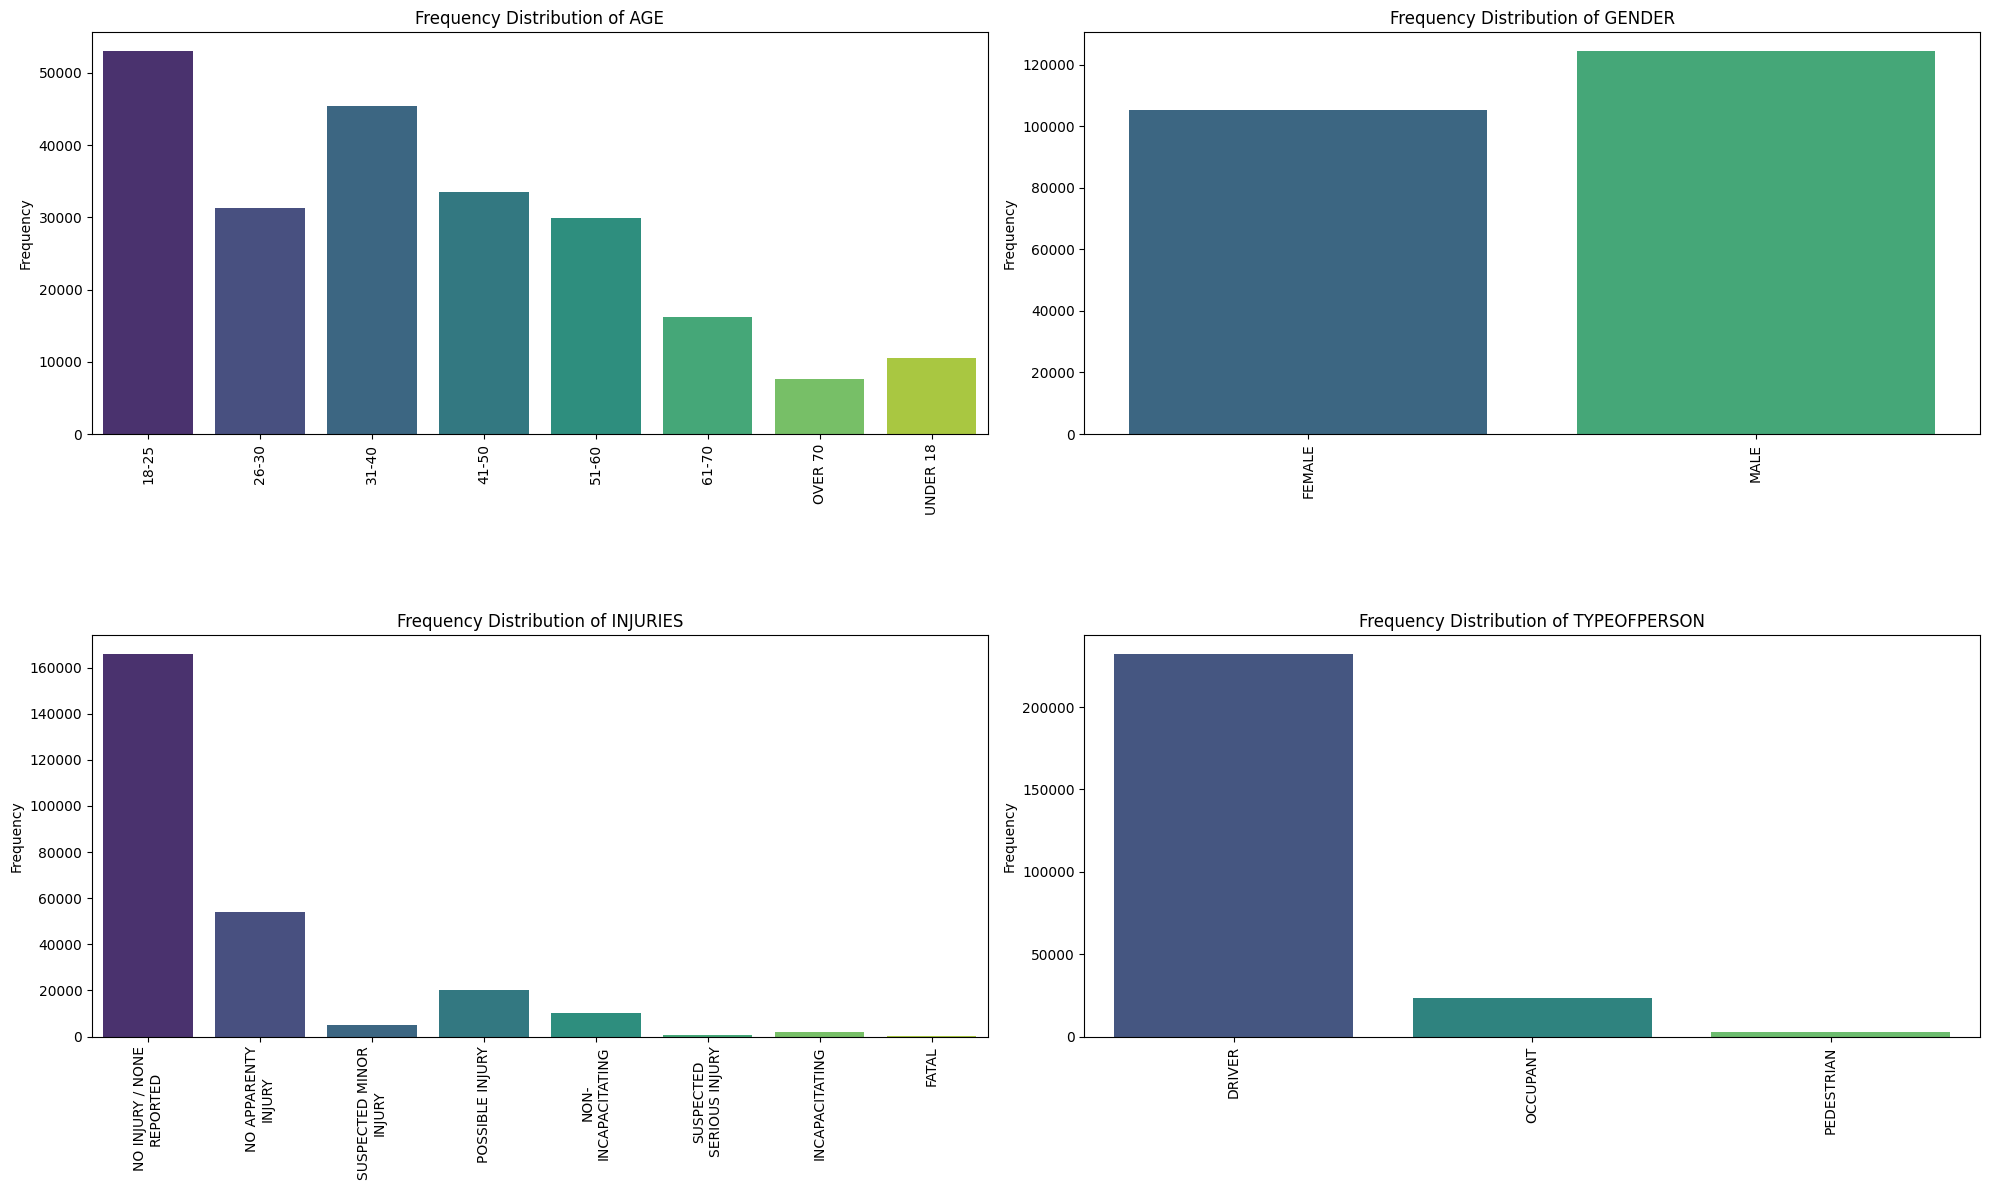

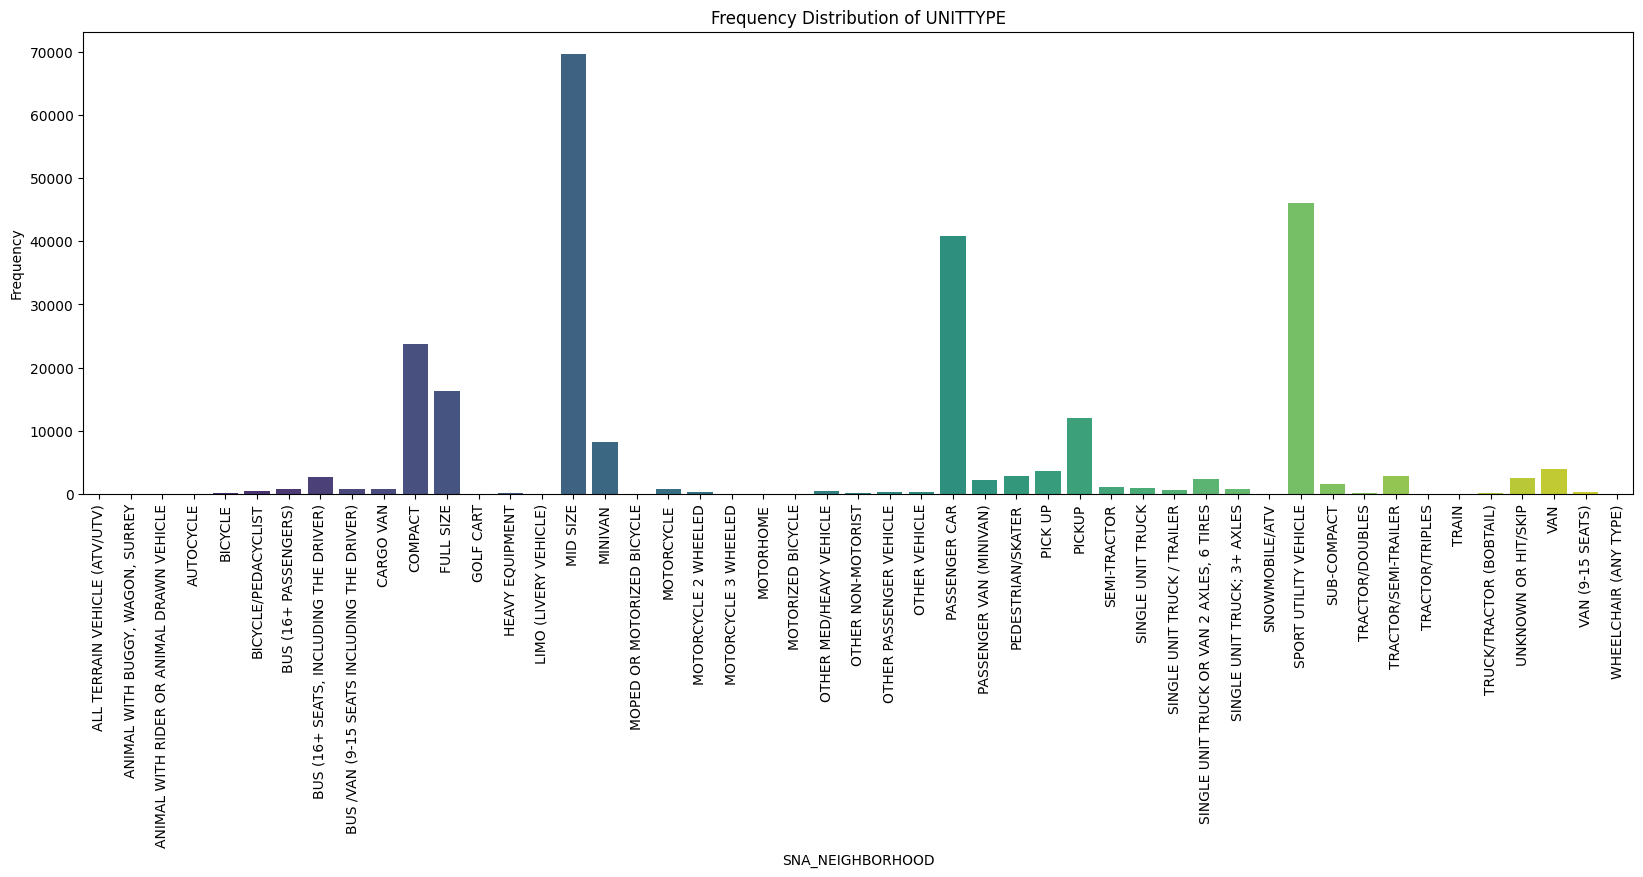

In [ ]:
# barplots of all the categorical variables

people_categorical_variables = [df.columns[0], df.columns[5],df.columns[6],df.columns[-3]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

axes = axes.flatten()

# Helper function to split long labels
def wrap_labels(ax, labels, width=16):
    wrapped_labels = [textwrap.fill(label, width) for label in labels]
    ax.set_xticklabels(wrapped_labels)

warnings.filterwarnings("ignore", category=UserWarning)

# BAR CHARTS
for i, var in enumerate(people_categorical_variables):
    filtered_var = df[var].replace('UNKNOWN', np.nan).dropna()
    if i < len(axes):
        ax = axes[i]
        sns.countplot(x=filtered_var, data=df, ax=ax, hue=filtered_var, palette='viridis', legend=False)
        ax.set_title(f'Frequency Distribution of {var}')
        ax.set_xlabel('')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=90)

        labels = [item.get_text() for item in ax.get_xticklabels()]
        wrap_labels(ax, labels)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# plot out of the grid for UNITTYPE, which counts much more modalities
filtered_UNITTYPE = df["UNITTYPE"].replace('UNKNOWN', np.nan).dropna()
plt.figure(figsize=(20, 6))
sns.countplot(x=filtered_UNITTYPE, hue=filtered_UNITTYPE, palette='viridis', dodge=False, legend=False)
plt.title('Frequency Distribution of UNITTYPE')
plt.xlabel('SNA_NEIGHBORHOOD')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


Most people belong either to the age range 18-25 (23.2%) or 31-40 (19.9%), while the least involved age ranges are under 18 (4.6%) and over 70 (3.3), with a slightly higher involvement of male figures (54%) compared to female ones (46%). In about 85% of the cases, people involved either suffered no injuries or minor ones, with fatal events occurring only about 0.09% of the times. In 90% of cases the involved people are drivers (to be considered that drivers are the only figure that will always be involved in a crash), in 9% of the cases they are passengers and in about 1% of the cases they are pedestrians. The most involved types of vehicles are mid-size units (27%), followed by sport utility vehicles (18%), and by passenger cars (16%).



# PEOPLE ANALYSIS

## CONTINGENCY TABLES

<font size="5"> AGE and INJURIES:

In [ ]:
filtered_vars = df[["AGE", "INJURIES"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['AGE'], filtered_vars['INJURIES'])

# expected frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+----------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
|   AGE    | NO INJURY / NONE REPORTED | NO APPARENTY INJURY | SUSPECTED MINOR INJURY | POSSIBLE INJURY | NON-INCAPACITATING | SUSPECTED SERIOUS INJURY | INCAPACITATING | FATAL |
+----------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
|  18-25   |           33979           |        10389        |          1158          |      4321       |        2526        |           118            |      447       |  34   |
|  26-30   |           19865           |        6340         |          687           |      2692       |        1394        |            81            |      270       |  32   |
|  31-40   |           28498           |        9743         |          1092          

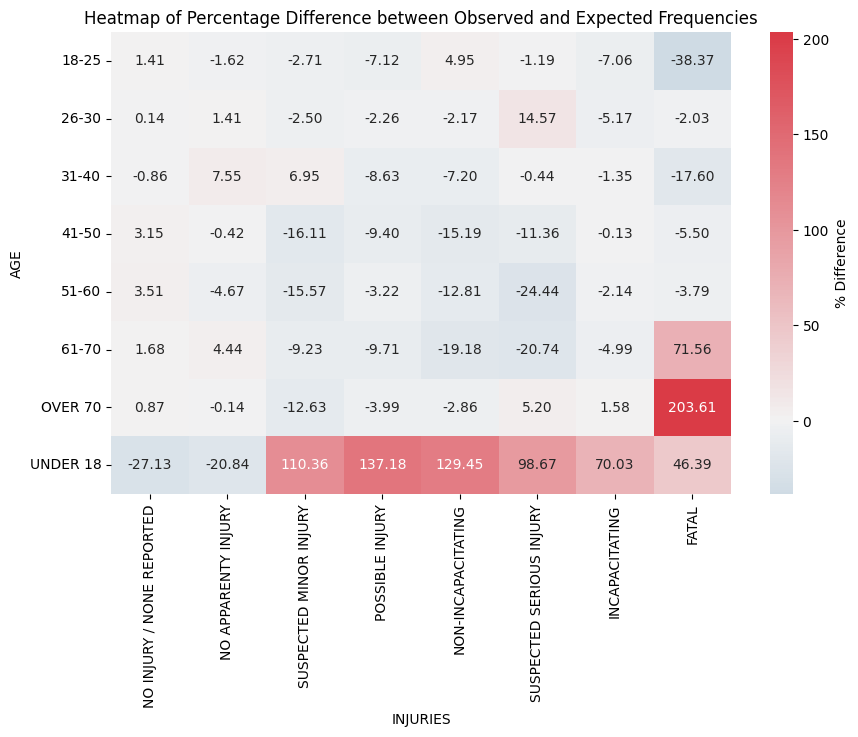

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('INJURIES')
plt.ylabel('AGE')
plt.show()


The data shows that fatal occurrences are more frequent than expected in the case of older people (71% more for 61-70 and 203% more for over 70) and for under 18 people (46.39% more). Under 18 people suffer harder injuries more often than expected and small/no injuries less than expected.


<font size="5"> GENDER and INJURIES:

In [ ]:
filtered_vars = df[["GENDER", "INJURIES"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['GENDER'], filtered_vars['INJURIES'])

# expected frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+--------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
| GENDER | NO INJURY / NONE REPORTED | NO APPARENTY INJURY | SUSPECTED MINOR INJURY | POSSIBLE INJURY | NON-INCAPACITATING | SUSPECTED SERIOUS INJURY | INCAPACITATING | FATAL |
+--------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
| FEMALE |           64265           |        20225        |          2675          |      11514      |        5374        |           219            |      914       |  68   |
|  MALE  |           80893           |        25755        |          2453          |      8617       |        4987        |           294            |      1153      |  172  |
+--------+---------------------------+---------------------+------------------------+-----------

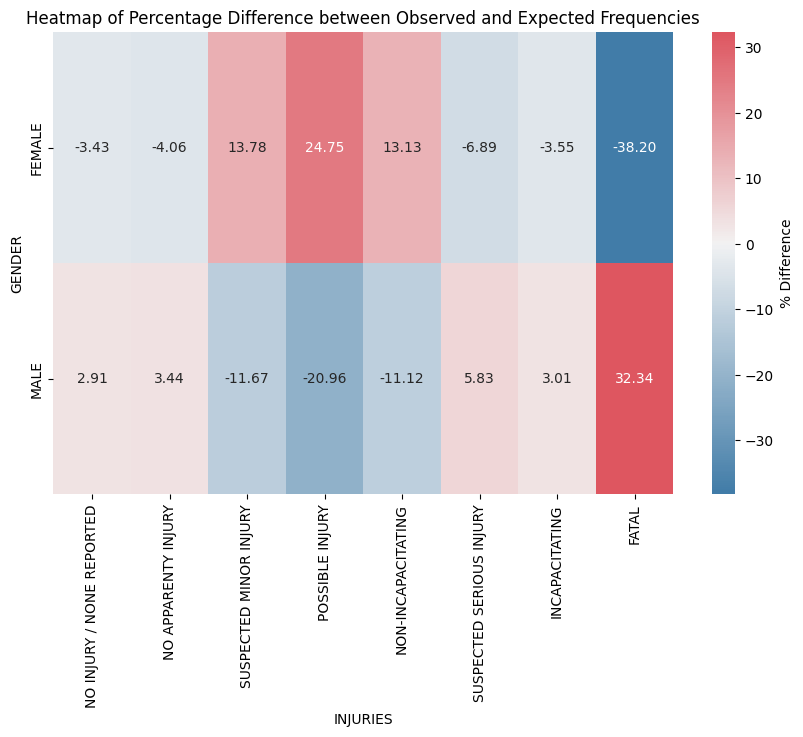

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('INJURIES')
plt.ylabel('GENDER')
plt.show()


The data shows evidence of females suffering possible injuries more than expected (25% more) and fatal injuries less than expected (38% less), with the opposite being true for males (21% fewer possible injuries and 32% more fatal injuries). To be noted that this could be due to third factors.

<font size="5"> TYPEOFPERSON and INJURIES:

In [ ]:
filtered_vars = df[["TYPEOFPERSON", "INJURIES"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['TYPEOFPERSON'], filtered_vars['INJURIES'])

# expected frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+--------------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
| TYPEOFPERSON | NO INJURY / NONE REPORTED | NO APPARENTY INJURY | SUSPECTED MINOR INJURY | POSSIBLE INJURY | NON-INCAPACITATING | SUSPECTED SERIOUS INJURY | INCAPACITATING | FATAL |
+--------------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
|    DRIVER    |          156569           |        50774        |          3392          |      13114      |        6660        |           303            |      1278      |  140  |
|   OCCUPANT   |           9223            |        3136         |          1373          |      6263       |        2740        |           127            |      460       |  46   |
|  PEDESTRIAN  |            122            |         46          |

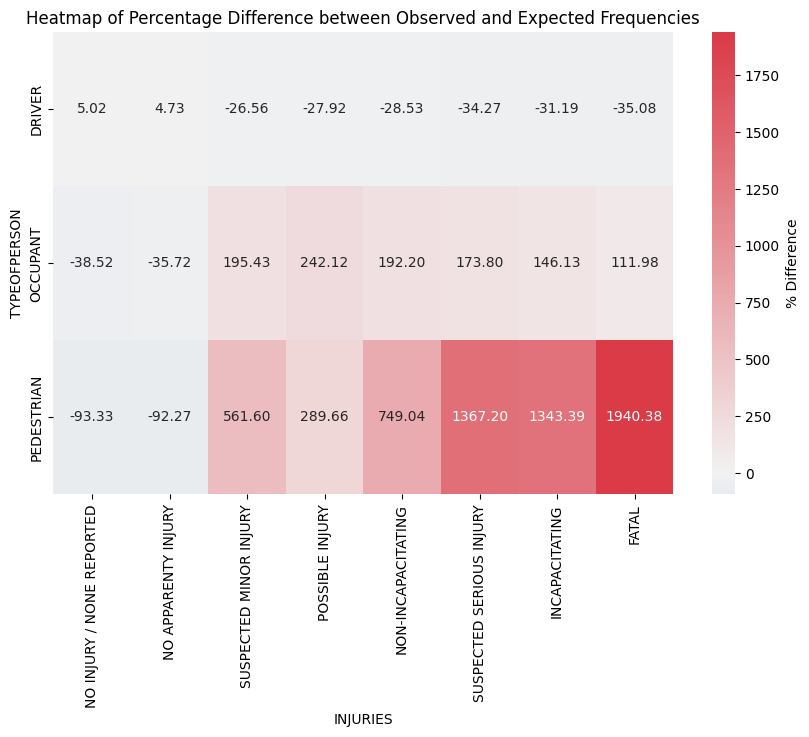

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('INJURIES')
plt.ylabel('TYPEOFPERSON')
plt.show()


The data shows that pedestrians often suffer much harder consequences than statistically expected from car crashes, with up to 2000% more fatal injuries, and 93% fewer "no injuries”. Occupants also show a (lighter) tendency to suffer harder consequences from crashes.

<font size="5"> UNITTYPE and INJURIES:

In [ ]:
filtered_vars = df[["UNITTYPE", "INJURIES"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['UNITTYPE'], filtered_vars['INJURIES'])

# expected frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+--------------------------------------------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
|                  UNITTYPE                  | NO INJURY / NONE REPORTED | NO APPARENTY INJURY | SUSPECTED MINOR INJURY | POSSIBLE INJURY | NON-INCAPACITATING | SUSPECTED SERIOUS INJURY | INCAPACITATING | FATAL |
+--------------------------------------------+---------------------------+---------------------+------------------------+-----------------+--------------------+--------------------------+----------------+-------+
|       ALL TERRAIN VEHICLE (ATV/UTV)        |             0             |          5          |           2            |        2        |         0          |            2             |       0        |   0   |
|      ANIMAL WITH BUGGY, WAGON, SURREY      |             2             |          0          |           0            |        

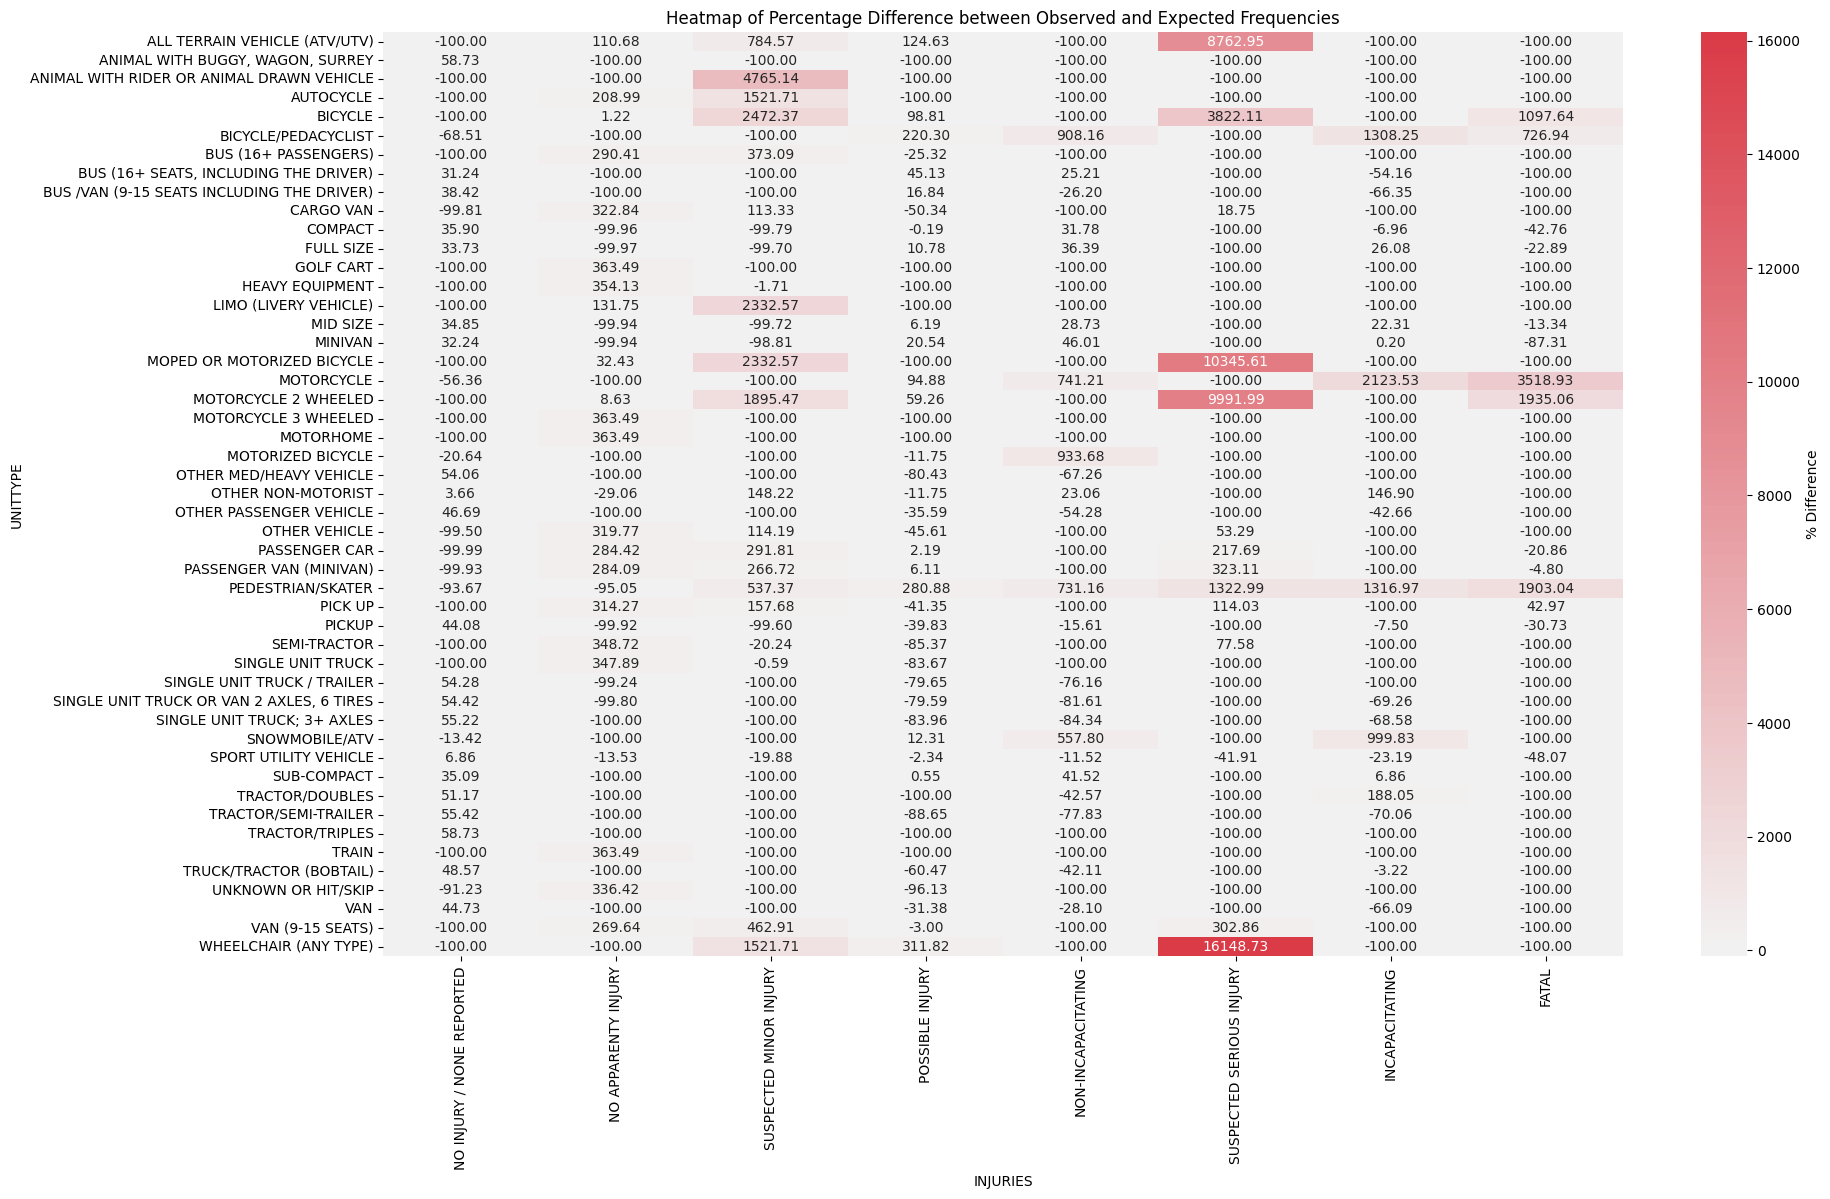

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('INJURIES')
plt.ylabel('UNITTYPE')
plt.show()


Wheelchairs and two-wheeled vehicles suffer more "suspected serious injuries" than expected.

# CRASHES ANALYSIS

## CONTINGENCY TABLES

<font size="5"> CRASHLOCATION and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["CRASHLOCATION", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['CRASHLOCATION'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+----------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|       CRASHLOCATION        | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+----------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|         CROSSOVER          |          61          |           0            |        0        |   23   |            0             |      0       |   0   |
|   DRIVEWAY/ALLEY ACCESS    |         1894         |           0            |        0        |  434   |            0             |      3       |   0   |
|    FIVE-POINT, OR MORE     |         200          |           0            |        0        |   48   |            0             |      1       |   0   |
|   FOUR-WAY INTERSECTION    |        13456  

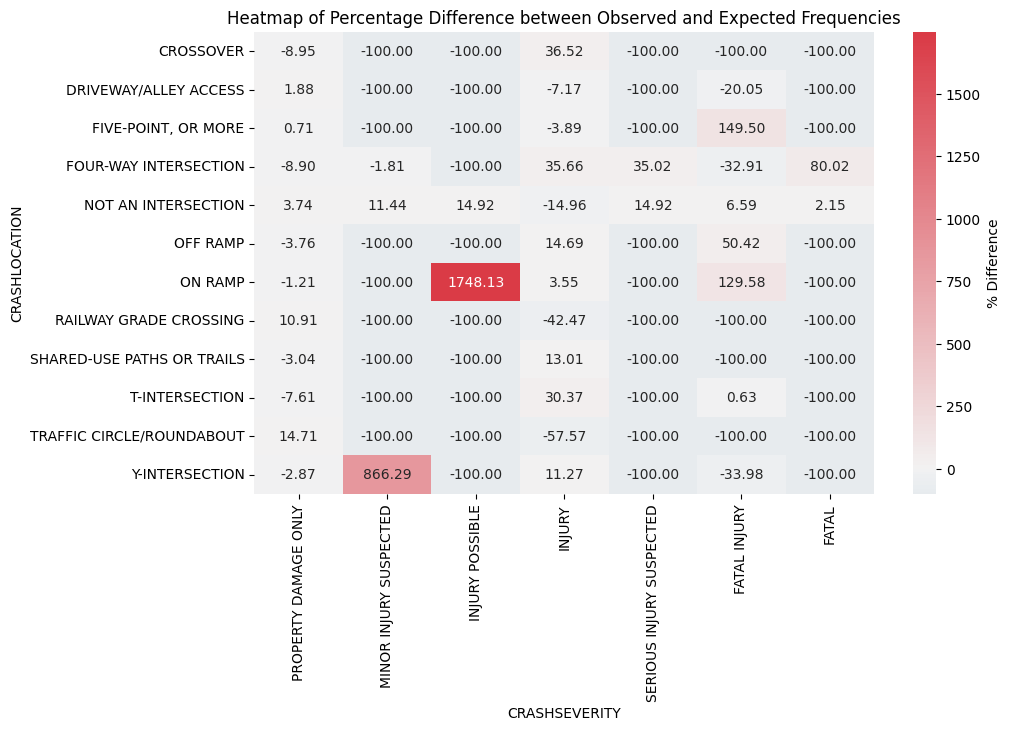

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('CRASHLOCATION')
plt.show()


On-ramp crashes show a much higher tendency of having crash severity as "injury possible" (1748% more), being the only location together with "not an intersection" to have this modality. Y intersection results much more often than expected in "minor injury suspected" (866% more than expected).


<font size="5"> DAYOFWEEK and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["DAYOFWEEK", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['DAYOFWEEK'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+-----------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
| DAYOFWEEK | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+-----------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|    FRI    |        17836         |          611           |       531       |  3300  |            75            |      36      |  12   |
|    MON    |        15172         |          558           |       417       |  2844  |            53            |      17      |   7   |
|    SAT    |        13656         |          534           |       462       |  2591  |            58            |      24      |  15   |
|    SUN    |        11099         |          470           |       356       |  2232  |            62            |      27      |  13   |
|    THU

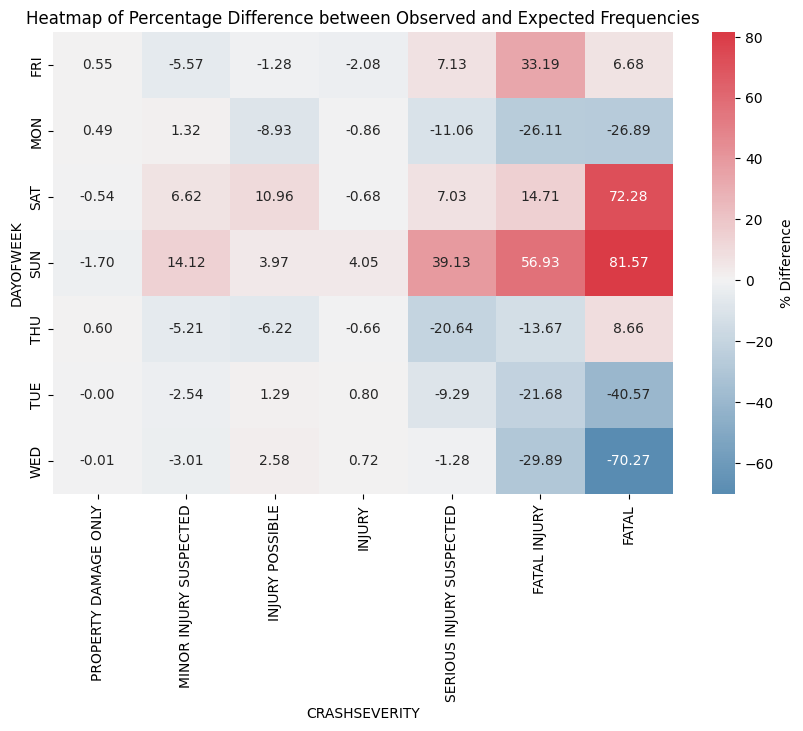

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('DAYOFWEEK')
plt.show()


Fatal events are much more common on a Saturday (72% more) and Sunday (81% more) and less common on a Wednesday (70% less) and on a Tuesday (40% less). Fatal injuries follow a similar trend.


<font size="5"> LIGHTCONDITIONSPRIMARY and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["LIGHTCONDITIONSPRIMARY", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['LIGHTCONDITIONSPRIMARY'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+---------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|     LIGHTCONDITIONSPRIMARY      | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+---------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|              DARK               |        25697         |          1214          |       780       |  5276  |           174            |      85      |  37   |
|   DARK – ROADWAY NOT LIGHTED    |         1659         |           51           |       43        |  192   |            12            |      2       |   2   |
| DARK – UNKNOWN ROADWAY LIGHTING |         758          |           17           |       12        |   50   |            2             |      0       |   0   |
|              

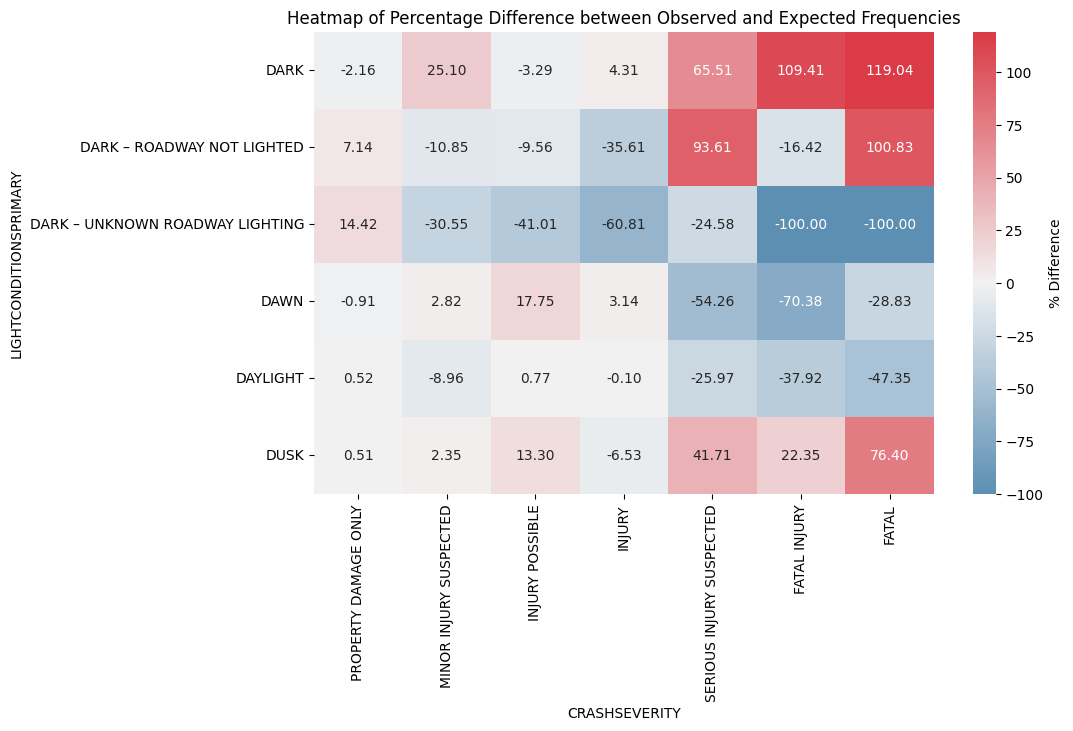

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('LIGHTCONDITIONSPRIMARY')
plt.show()


Dark conditions of the road generally result in more severe crashes than expected.



<font size="5"> MANNEROFCRASH and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["MANNEROFCRASH", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['MANNEROFCRASH'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+-------------------------------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|                     MANNEROFCRASH                     | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+-------------------------------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|                         ANGLE                         |        25552         |          1325          |      1042       |  6467  |           104            |      33      |  13   |
|                        BACKING                        |         4666         |           12           |       27        |  173   |            2             |      0       |   0   |
|                        HEAD-ON                        |         

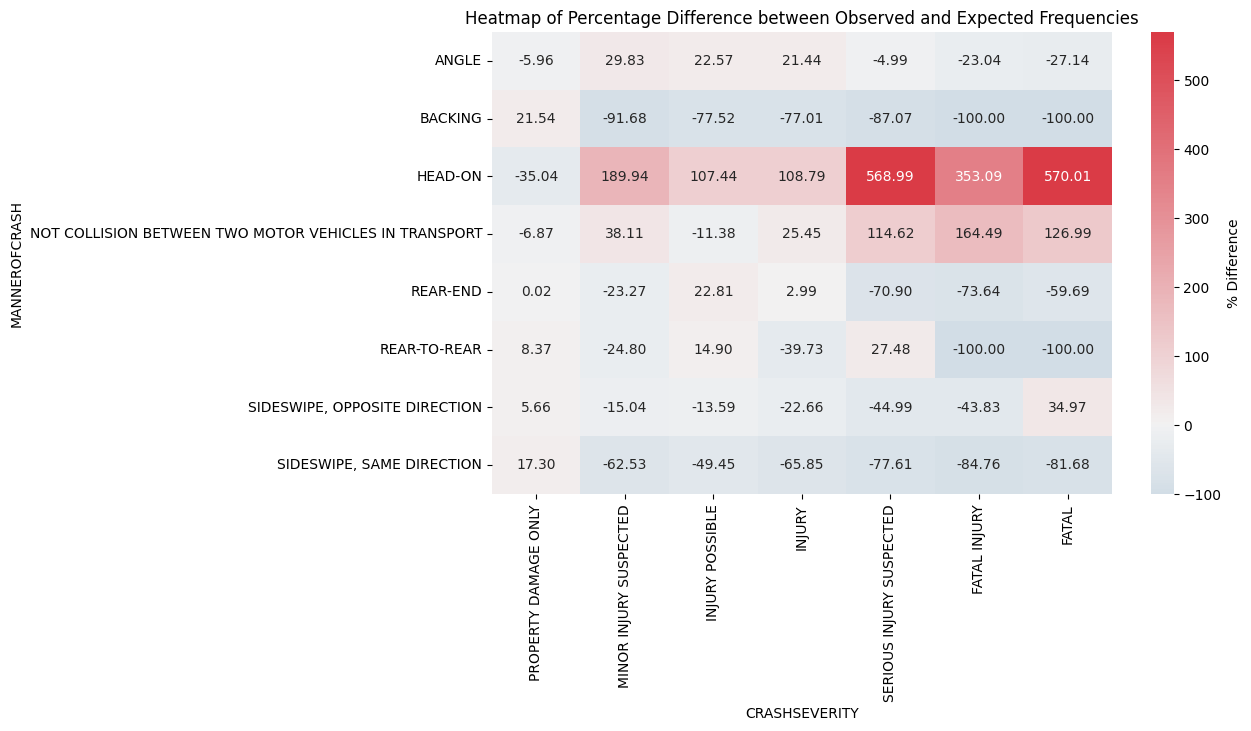

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('MANNEROFCRASH')
plt.show()


Head-on crashes show much higher counts of injuries, and especially severe injuries (570% more fatal events than expected, 569% more serious injuries suspected than expected, 353% more fatal injuries than expected) and fewer "property damage only" crashes than expected (35% less). The modality "Not collision between two motor vehicles in transport" follows a similar, less pronounced, trend (164% more fatal injuries than expected).

<font size="5"> ROADCONDITIONSPRIMARY and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["ROADCONDITIONSPRIMARY", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['ROADCONDITIONSPRIMARY'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|    ROADCONDITIONSPRIMARY     | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|             DRY              |        79361         |          2872          |      2408       | 14690  |           322            |     128      |  53   |
|             ICE              |         965          |           34           |       23        |  177   |            4             |      0       |   0   |
| SAND, MUD, DIRT, OIL, GRAVEL |          63          |           3            |        4        |   10   |            1             |      0       |   0   |
|            SLUSH             | 

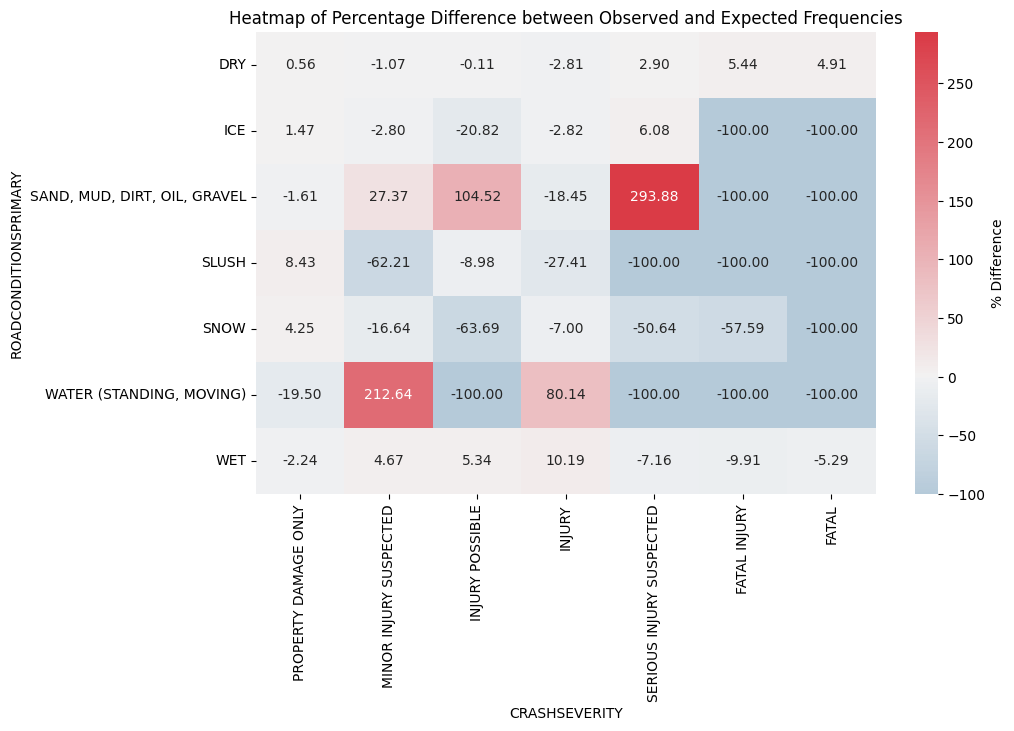

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('ROADCONDITIONSPRIMARY')
plt.show()


Roads covered in water result in a higher number of minor injuries suspected (212% more than expected) but do not show any serious injury suspected nor fatal occurrences. Sand, mud, dirt, oil, and gravel roads are slightly more dangerous, resulting in 293% more serious injuries suspected than expected, but still no fatal occurrences.


<font size="5"> ROADCONTOUR and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["ROADCONTOUR", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['ROADCONTOUR'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+----------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|  ROADCONTOUR   | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+----------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|  CURVE GRADE   |         6394         |          335           |       215       |  1813  |            57            |      35      |  14   |
|  CURVE LEVEL   |         4857         |          242           |       168       |  1206  |            44            |      21      |  13   |
| STRAIGHT GRADE |        20743         |          763           |       596       |  4378  |            70            |      32      |   8   |
| STRAIGHT LEVEL |        73531         |          2513          |      2224       | 12674  |           246          

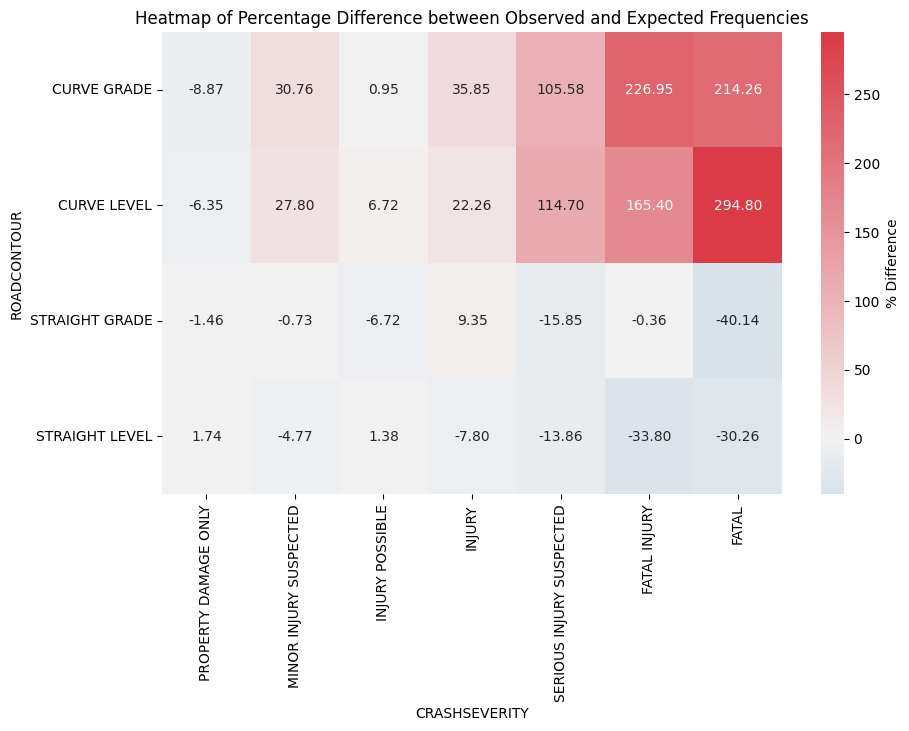

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('ROADCONTOUR')
plt.show()


Curved road contours are much more dangerous than straight ones, with both curve grade and curve level road contours showing more serious injuries suspected (105% and 114% more, respectively), fatal injuries (226% and 165% more, respectively), and fatal (214% and 294% more, respectively) than expected.

<font size="5"> ROADSURFACE and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["ROADSURFACE", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['ROADSURFACE'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+-------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|          ROADSURFACE          | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+-------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
| BLACKTOP, BITUMINOUS, ASPHALT |        87932         |          3331          |      2808       | 16890  |           370            |     145      |  61   |
|          BRICK/BLOCK          |         239          |           3            |        3        |   50   |            0             |      0       |   0   |
|           CONCRETE            |        17213         |          513           |       391       |  3112  |            47            |      16      |   6   |
|             DIRT         

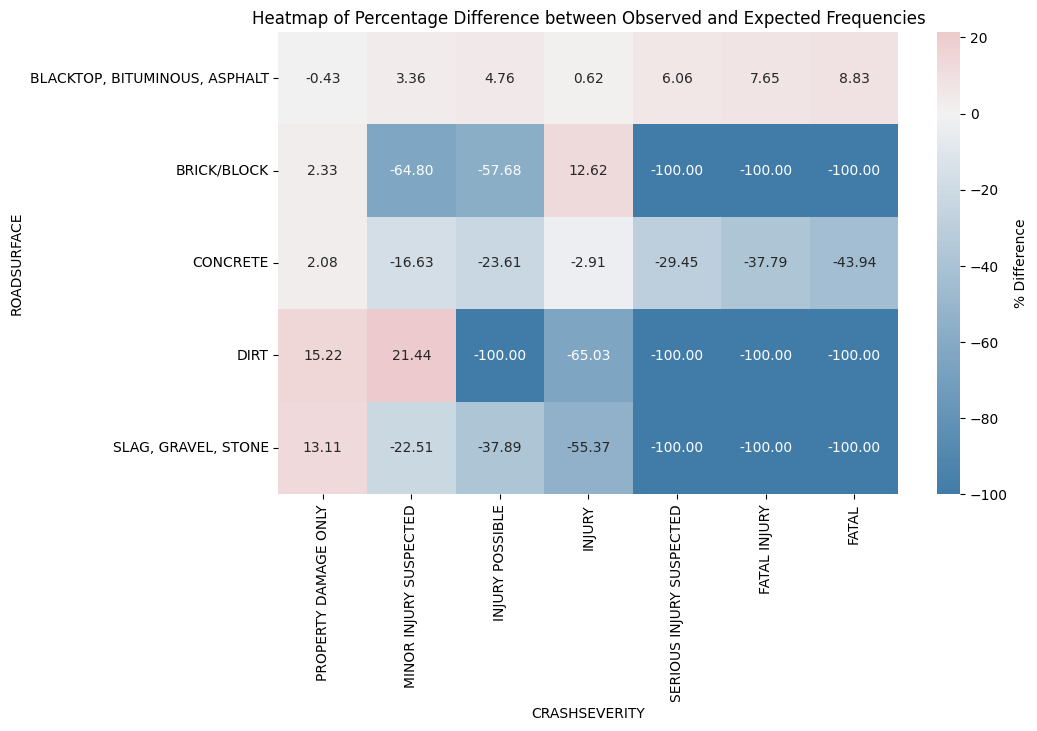

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('ROADSURFACE')
plt.show()


Brick, block, dirt, slag, gravel, and stone are surfaces that do not show the highest levels of injuries.

<font size="5"> SNA_NEIGHBORHOOD and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["SNA_NEIGHBORHOOD", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()

# contingency table
contingency_table = pd.crosstab(filtered_vars['SNA_NEIGHBORHOOD'], filtered_vars['CRASHSEVERITY'])

# expeted frequencies
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# expected frequencies contingency table
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

print("Contingency Table:")
print(table_str)

print("\nExpected Frequencies:")
print(expected_freq_str)


Contingency Table:
+--------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|        SNA_NEIGHBORHOOD        | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+--------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|            AVONDALE            |         5226         |          174           |       175       |  1110  |            23            |      9       |   3   |
|           BOND HILL            |         3651         |          140           |       108       |  760   |            12            |      8       |   2   |
|           CALIFORNIA           |         447          |           13           |       14        |  103   |            2             |      4       |   2   |
|        CAMP WASHING

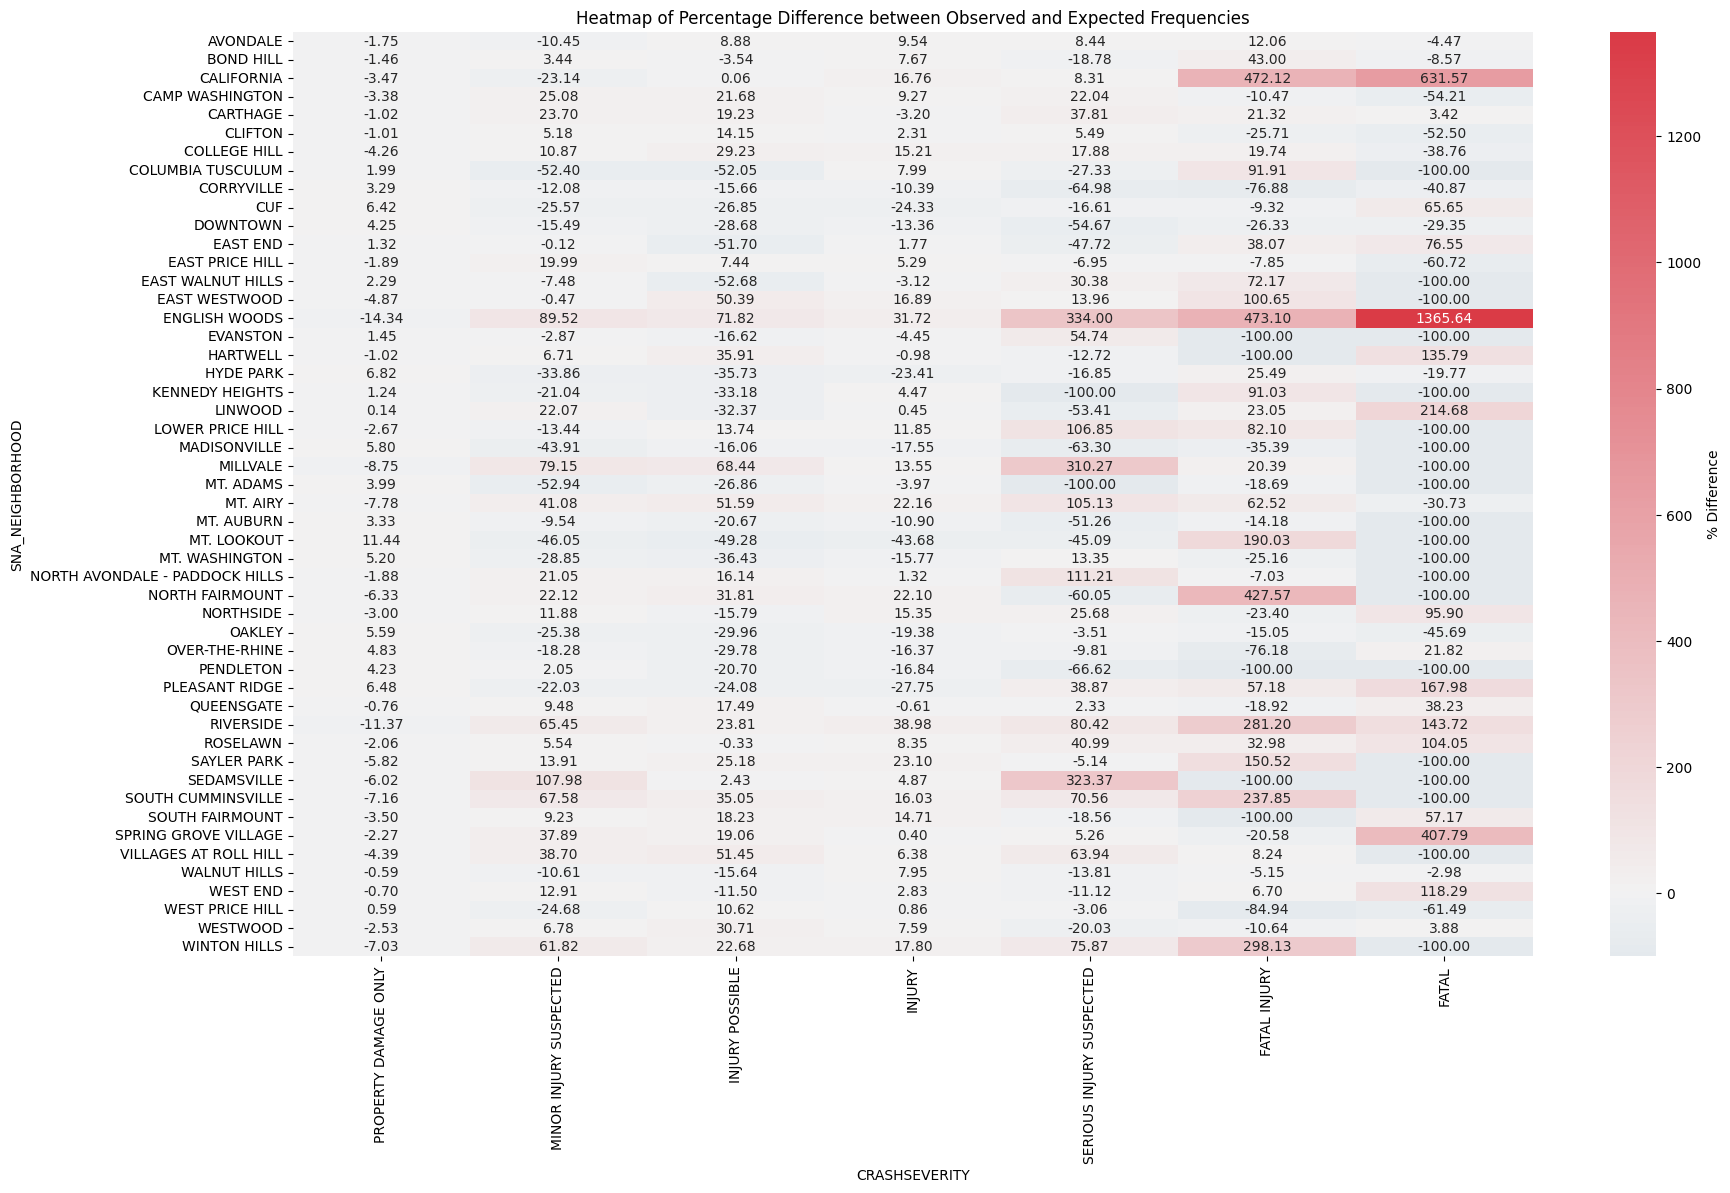

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('SNA_NEIGHBORHOOD')
plt.show()


English Woods seems to be the neighborhood with the highest values of severe injuries compared to what was expected, followed by the California one.


<font size="5"> WEATHER and CRASHSEVERITY:

In [ ]:
filtered_vars = df_crashes[["WEATHER", "CRASHSEVERITY"]].replace('UNKNOWN', np.nan).dropna()
contingency_table = pd.crosstab(filtered_vars['WEATHER'], filtered_vars['CRASHSEVERITY'])

# Perform chi-square test of independence to get expected frequencies, chi-square statistic, p-value, and degrees of freedom
chi2, p, dof, expected_freq = chi2_contingency(contingency_table)

# Format contingency table using tabulate
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')

# Format expected frequencies as DataFrame and then using tabulate
expected_freq_df = pd.DataFrame(expected_freq, index=contingency_table.index, columns=contingency_table.columns)
expected_freq_str = tabulate(expected_freq_df, headers='keys', tablefmt='pretty')

# Print formatted contingency table
print("Contingency Table:")
print(table_str)

# Print formatted expected frequencies
print("\nExpected Frequencies:")
print(expected_freq_str)

# Print results of the chi-square test
print("\nResults of Chi-square Test:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Contingency Table:
+-----------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|              WEATHER              | PROPERTY DAMAGE ONLY | MINOR INJURY SUSPECTED | INJURY POSSIBLE | INJURY | SERIOUS INJURY SUSPECTED | FATAL INJURY | FATAL |
+-----------------------------------+----------------------+------------------------+-----------------+--------+--------------------------+--------------+-------+
|  BLOWING SAND, SOIL, DIRT, SNOW   |          20          |           0            |        0        |   5    |            0             |      0       |   0   |
|               CLEAR               |        68536         |          2554          |      2109       | 12613  |           291            |     103      |  40   |
|              CLOUDY               |        18084         |          588           |       555       |  3804  |            57            |      37      |  15   |
|  

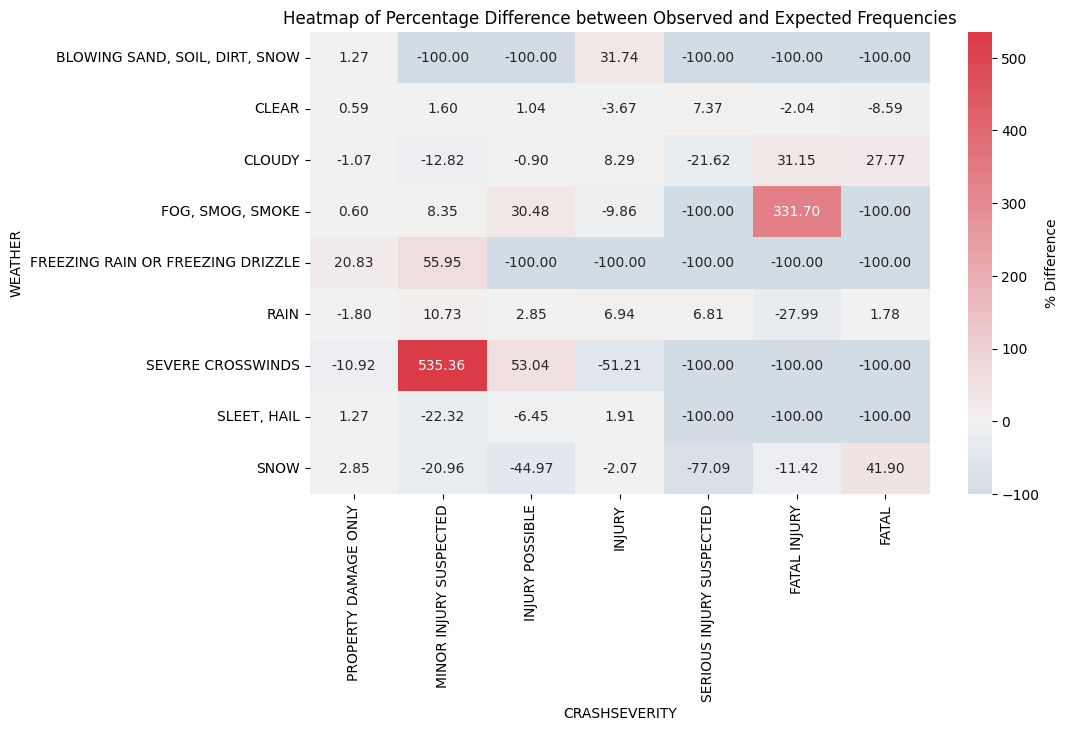

In [ ]:
# difference between expected frequencies and actual fequencies

percentage_diff = (contingency_table - expected_freq_df) / expected_freq_df * 100

pd.options.display.float_format = '{:,.2f}'.format

# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_diff, annot=True, fmt='.2f', cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0, cbar_kws={'label': '% Difference'})
plt.title('Heatmap of Percentage Difference between Observed and Expected Frequencies')
plt.xlabel('CRASHSEVERITY')
plt.ylabel('WEATHER')
plt.show()


Severe crosswinds result in fewer property damage only situations (11% less than expected) and in way more minor injuries suspected (535% more than expected), with no serious injury suspected, fatal injuries, and fatal events. Fog, smog, and smoke are the most dangerous conditions, with 331% more fatal injuries than expected. Snow conditions are also dangerous, with 42% more fatal events than expected.

## PREDICTIONS

In this section it is attempted to develop models to predict with some degree of effectiveness the gravity of a crash given the conditions in which it occurs, to get valuable insights to prevent the most critical situations.

<font size="5"> Preparing the data for the models:

In [ ]:
df_crashes_filtered = df_crashes.copy()
df_crashes_filtered = df_crashes_filtered.drop('CRASHDATE', axis=1)
df_crashes_filtered = df_crashes_filtered.replace('UNKNOWN', np.nan).dropna()
print(df_crashes_filtered["CRASHSEVERITY"].value_counts())
# this is needed because low frequency variables pose a thret to the efficiency of the models
df_merging_dict = {
    "FATAL" : "FATAL INJURY",
    "INJURY POSSIBLE" : "INJURY",
    "MINOR INJURY SUSPECTED" : "INJURY",
    "SERIOUS INJURY SUSPECTED" : "INJURY"
}
df_crashes_filtered['CRASHSEVERITY'] = df_crashes_filtered['CRASHSEVERITY'].replace(df_merging_dict)

X = df_crashes_filtered.drop('CRASHSEVERITY', axis=1)
y = df_crashes_filtered['CRASHSEVERITY']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.15, random_state=42)


CRASHSEVERITY
PROPERTY DAMAGE ONLY        74310
INJURY                      19536
FATAL INJURY                  156
MINOR INJURY SUSPECTED         10
SERIOUS INJURY SUSPECTED        8
INJURY POSSIBLE                 3
FATAL                           3
Name: count, dtype: int64


Before developing the model, the crashed dataset was filtered of all crashes having at least one UNKNOWN value, other than having the CRASHDATE variable removed. Because of the significant reduction in information, some crash severity classes have been merged to have more populated and different classes, the following:
*   Property damage only: includes Property damage only
*   Injury: includes Injury, Minor injury suspected, Injury possible, Serious injury suspected
*   Fatal injury: includes Fatal injury, Fatal

Because of the high imbalance in class populations, the chosen valuation metric is the f1 score,
computed as the harmonic mean of precision and recall, where precision is the ratio of true positives
to the sum of true and false positives, and recall is the ratio of true positives to the sum of true
positives and false negatives, attenuating misleadingly high scores from one dominant class.

<font size="5"> K nearest neighbours:

F1-Score: 0.7198
                      precision    recall  f1-score   support

        FATAL INJURY       0.00      0.00      0.00        32
              INJURY       0.32      0.13      0.19      2911
PROPERTY DAMAGE ONLY       0.80      0.93      0.86     11161

            accuracy                           0.76     14104
           macro avg       0.38      0.35      0.35     14104
        weighted avg       0.70      0.76      0.72     14104



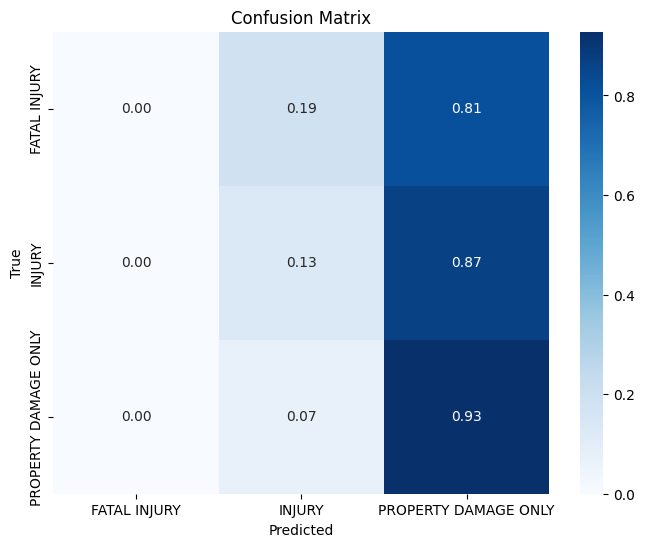

In [ ]:
# Train the model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred_knn, average='weighted')
print(f'F1-Score: {f1:.4f}')
print(classification_report(y_test, y_pred_knn))

conf_matrix = confusion_matrix(y_test, y_pred_knn)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',  fmt='.2f', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The reason behind the good score of this model is that it tends to always predict property damage only, which is statistically good but not relevant for the purpose of this work, especially given that the higher interest of the analysis is posed on more severe crashes.

<font size="5"> Gradient boosting:

F1-Score: 0.7180
                      precision    recall  f1-score   support

        FATAL INJURY       0.00      0.00      0.00        32
              INJURY       0.59      0.05      0.09      2911
PROPERTY DAMAGE ONLY       0.80      0.99      0.88     11161

            accuracy                           0.79     14104
           macro avg       0.46      0.35      0.32     14104
        weighted avg       0.75      0.79      0.72     14104



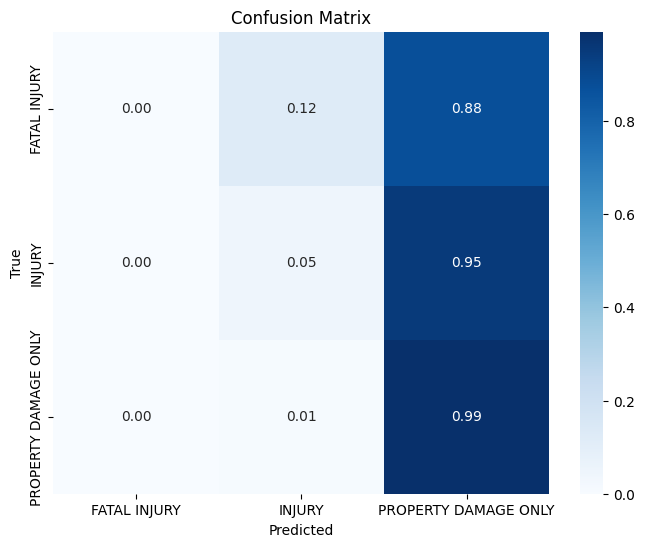

In [ ]:
# Train the model
gbc_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_model.fit(X_train, y_train)

# Make predictions
y_pred_gbc = gbc_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred_gbc, average='weighted')
print(f'F1-Score: {f1:.4f}')
print(classification_report(y_test, y_pred_gbc))

conf_matrix = confusion_matrix(y_test, y_pred_gbc)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',  fmt='.2f', xticklabels=gbc_model.classes_, yticklabels=gbc_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The Gradient boosting algorithm shows the same problem of "always predict property damage only" as knn, here even more accentuated.

<font size="5"> Random forests:

F1-Score: 0.6218
                      precision    recall  f1-score   support

        FATAL INJURY       0.00      0.00      0.00        32
              INJURY       0.24      0.44      0.31      2911
PROPERTY DAMAGE ONLY       0.81      0.63      0.71     11161

            accuracy                           0.59     14104
           macro avg       0.35      0.36      0.34     14104
        weighted avg       0.69      0.59      0.62     14104



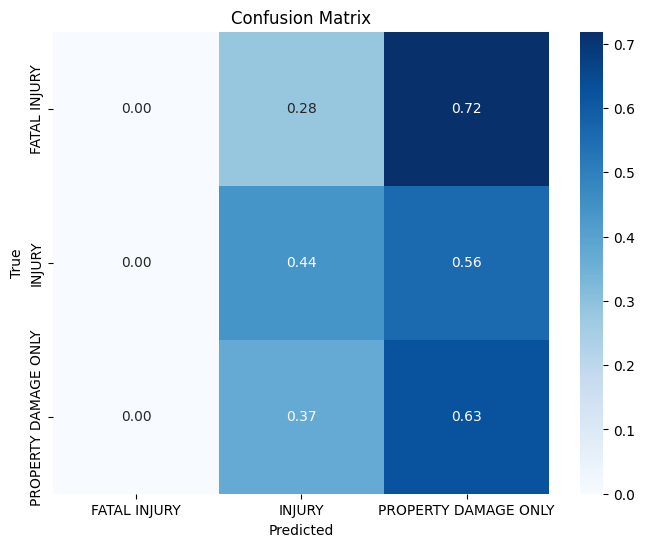

In [ ]:
class_name_mapping = {
    'FATAL INJURY': 15,
    'INJURY': 1,
    'PROPERTY DAMAGE ONLY': 0.001,
}

rf_model = RandomForestClassifier(n_estimators=100, random_state=42,  class_weight=class_name_mapping)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f'F1-Score: {f1:.4f}')
print(classification_report(y_test, y_pred_rf))


conf_matrix = confusion_matrix(y_test, y_pred_rf)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The random forest model has the option to assign a weight to the classes to impact the score of their performance, and this allows to partially overcome the previously presented issue. In this case, this allowed to predict more accurately the injury class, which is the second most common after property
damage only, but still the model prefers to never predict fatal injury, as the reward it gets is just too little, even in case of higher class weight. I still value this model's performance compared to the knn one and the GBA one, regardless of a lower f1 score.

<font size="5"> Logistic regression:

F1-Score: 0.6274
                      precision    recall  f1-score   support

        FATAL INJURY       0.01      0.47      0.01        32
              INJURY       0.29      0.43      0.35      2911
PROPERTY DAMAGE ONLY       0.86      0.60      0.70     11161

            accuracy                           0.56     14104
           macro avg       0.38      0.50      0.35     14104
        weighted avg       0.74      0.56      0.63     14104



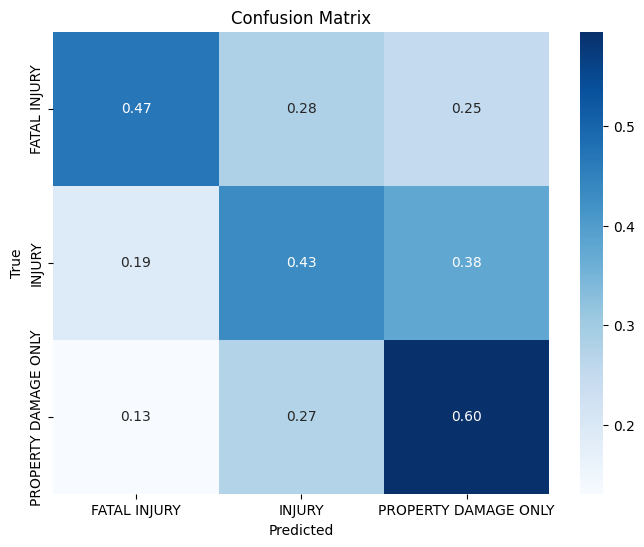

In [ ]:
class_name_mapping = {
    'FATAL INJURY': 100,
    'INJURY': 1,
    'PROPERTY DAMAGE ONLY': 0.3,
}
# Train the model
logreg_model = LogisticRegression(max_iter=1000, class_weight=class_name_mapping, random_state=42)
logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred_logreg, average='weighted')
print(f'F1-Score: {f1:.4f}')
print(classification_report(y_test, y_pred_logreg))

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',  fmt='.2f', xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Logistic regression allows, just like random forests, to have the classes weighted. Even with an f1 score of 0.62, this is the best developed model of the analysis, managing to capture in the best way among the ones attempted, the outcome of fatal injuries, other than injuries and property damage only.

<font size="5"> Features importance:

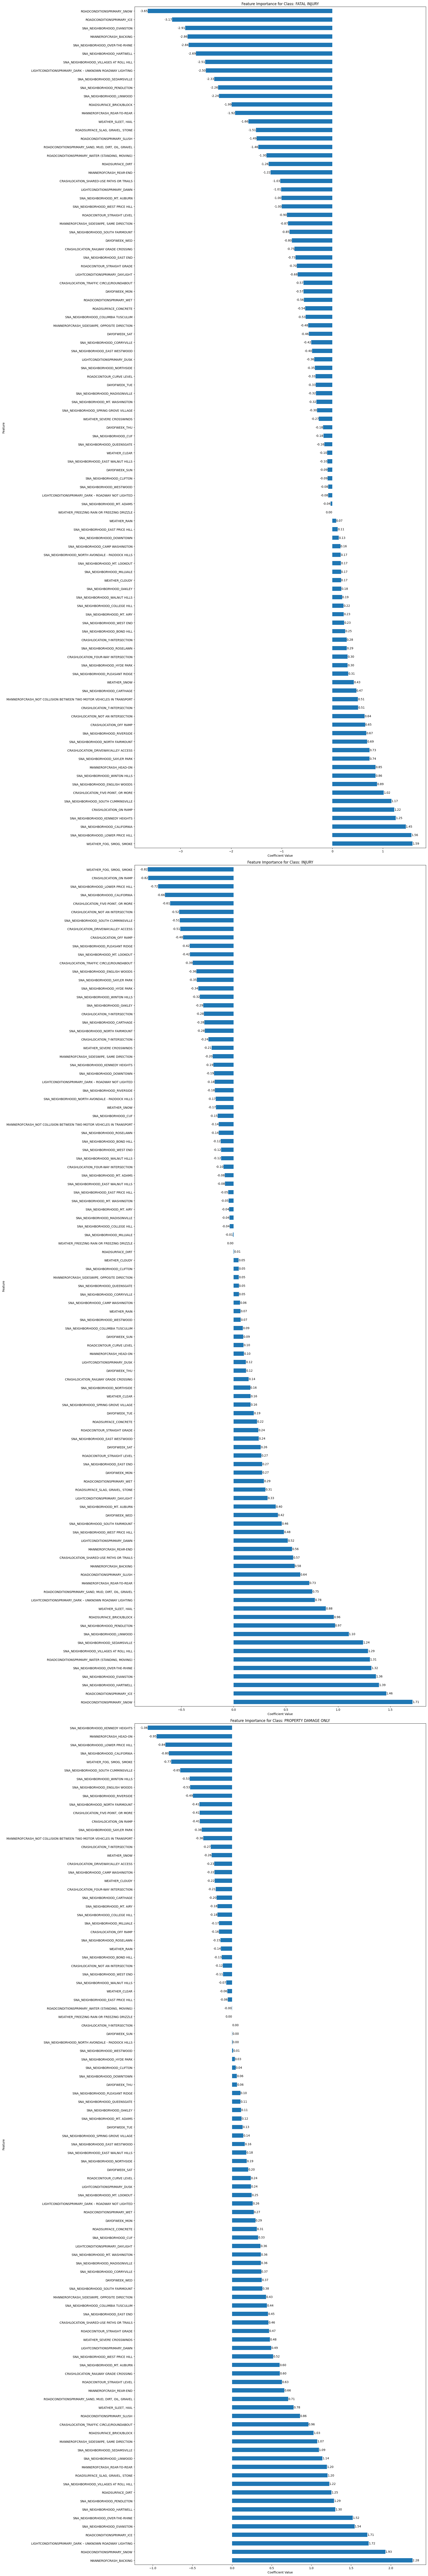

In [ ]:
feature_names = X_train.columns
coefficients = logreg_model.coef_
coef_df = pd.DataFrame(coefficients.T, columns=logreg_model.classes_, index=feature_names)

# plot coefficients for each class
fig, axes = plt.subplots(nrows=len(logreg_model.classes_), ncols=1, figsize=(20, 40*len(logreg_model.classes_)))
for i, class_name in enumerate(logreg_model.classes_):
    ax = axes[i] if len(logreg_model.classes_) > 1 else axes
    sorted_coefs = coef_df[class_name].sort_values(ascending=False)
    sorted_coefs.plot(kind='barh', ax=ax)
    ax.set_title(f'Feature Importance for Class: {class_name}')
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Feature')

    for j, (value, name) in enumerate(zip(sorted_coefs, sorted_coefs.index)):
        ax.text(value, j, f'{value:.2f}', va='center', ha='left' if value > 0 else 'right', color='black')

plt.tight_layout()
plt.show()


This analysis of the features refers to the chosen model, the logistic regression. It allows to have a look inside the model, to understand what is it that it uses to predict each class, to propend towards and away from it (the higher the absolute value of the coefficient higher the weight of the variable).


# Conclusions:

There are not many strong indicators of the fact that a crash will result in either property damage only or in an injury. Strong indicators of the fact that a car might not result in a fatality are many neighborhoods, including Evanston, Over the Rhine, Hartwell, Pendleton, Villages at Roll Hill,
Linwood, and Sedamsville, (that are also indicators of crashes resulting in property damage only or injuries) but also Mt auburn, and West price hill.
Other modalities that go against the prediction of a crash being fatal are unknown roadway lightning; backing or rear to rear manner of crash; snow, ice, and water conditions of the road; brick/block, slag/gravel/stone, or dirty surface of the road; all these are also features that make the model heavily
propend towards prediction of non fatal crashes; and then there are also: dawn light of the street; rear end manner of crash, sandy/muddy/oily/gravel road surface; and shared used path or trails as crash location. Elements to which it must be paid close attention, as they are strong indicators of fatal crashes are: on ramp and five point or more crash locations; Lower Price Hill, California, Kennedy Heights, and South Cumminsville neighborhoods: and the most impactful feature, which is fog/smoke/smog in the weather. weather conditions, namely snow and ice, are also the most important feature to predict
crashes resulting in injuries, according to the model.

In conclusion, it would be advised to take action in the following neighborhoods to lower the number of fatal crashes: Lower Price Hill, California, Kennedy Heights, and South Cumminsville; for example, lowering the speed limit and imposing stricter traffic rules near ramps and in the proximity of five points (or more). It is advised to the drivers to avoid as much as possible to drive in case of altered conditions of the road surface (water, snow, or ice) and especially in case of adverse weather, including fog, smoke or smog in the air. People under 18 and over 61 should pay extra attention while inside vehicles, making sure to adopt the mandatory and also the suggested safety measures always, as they have been found to be the
most fragile people. Increasing controls on weekends is also suggested, as these days tend to be the ones in which the worst crashes happen.




